<a href="https://colab.research.google.com/github/tarabelo/2024-VIU-Quantum/blob/main/Algoritmos%20cu%C3%A1nticos%20cl%C3%A1sicos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalamos qiskit en el notebook
!pip install qiskit qiskit-aer qiskit-ibm-runtime pylatexenc

In [69]:
import numpy as np
from math import sqrt

# importing Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator, UnitarySimulator, StatevectorSimulator

# import basic plot tools
from qiskit.visualization import plot_histogram

# Funciones auxiliares

# Función para simular y mostrar el vector de estado
def obten_estado(qcirc, etiqueta):
    # Hacemos una simulación y obtenemos los resultados
    sim = StatevectorSimulator()
    qc_obj = transpile(qcirc, sim)
    result = sim.run(qc_obj).result()
    estado = result.get_statevector()
    display(estado.draw('latex', prefix=etiqueta))
    display(estado.draw('bloch'))

# Funcion para obtener y mostrar la matriz unitaria
def obten_unitaria(qcirc, etiqueta):
    sim_u = UnitarySimulator()
    qc_obj = transpile(qcirc, sim_u)
    result = sim_u.run(qcirc).result()
    unitary = result.get_unitary(qcirc)
    display(unitary.draw('latex', prefix=etiqueta))

# **Algoritmos cuánticos "clásicos"**

Algoritmos que presentan una ventaja real sobre sus homólogos cuánticos

 - Introducidos en los años 90 del siglo XX
 - Suponen que tenemos computadores cuánticos ideales
 - Algunos de ellos carecen de utilidad práctica, mientras que otros suelen formar parte de algoritmos más complejos.

Contenidos

1. [Paralelismo cuántico](#paralelismo)
2. [Algoritmo "simples": Deutsch, Deutsch-Jozsa, Bernstein-Vazirani, Simon](#simples)
5. [Algoritmo de búsqueda de Grover: amplificación de amplitud](#grover)
1. [Transformada de Fourier cuántica (QFT)](#qft)
1. [Quantum phase estimation (QPE)](#qpe)
1. [Algoritmo de factorización de Shor](#shor)

# **Paralelismo cuántico** <a name="paralelismo"></a>

Permite evaluar una función $f(x)$ para múltiples valores de $x$ simultáneamente.

Sea $f(x): \{0,1\}\rightarrow\{0,1\}$. Para poder usar esa función en un sistema cuántico tenemos que obtener una unitaria $U_f$ que la implemente. Una forma simple es:


<center><img src="https://drive.google.com/uc?export=view&id=1wE_Ts7MoneY2S4p11SqYHT4o0_SI7vEd" alt="Puerta reversible" width="300"  /></center>

Es fácil ver que $U_f$ es su propia inversa:

<center><img src="https://drive.google.com/uc?export=view&id=1pHBMmR3su74ziSuXJK0p9zr1sAGejti_" alt="Puerta reversible demo" width="600"  /></center>

Para un sistema de dos cúbits $|yx\rangle=|y\rangle\otimes|x\rangle$ (siguiendo el orden de Qiskit) tenemos:

$$
U_f|yx\rangle = |y\oplus f(x)\rangle\otimes|x\rangle
$$

Si hacemos $|x\rangle = \tfrac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$ e $|y\rangle=|0\rangle$:

$$
\begin{aligned}
U_f\left(|0\rangle\otimes|\tfrac{1}{\sqrt{2}}(|0\rangle+|1\rangle)\rangle\right) &
= U_f\left(|\tfrac{1}{\sqrt{2}}(|00\rangle+|01\rangle)\right)
= \tfrac{1}{\sqrt{2}}\left(U_f|00\rangle+U_f|01\rangle\right) \\
& = \tfrac{1}{\sqrt{2}}\left(|0\oplus f(0)\rangle\otimes|0\rangle+|0\oplus f(1)\rangle\otimes|1\rangle\right)
= \tfrac{1}{\sqrt{2}}\left(|f(0)\rangle\otimes|0\rangle+|f(1)\rangle\otimes|1\rangle\right)
\end{aligned}
$$

Una única aplicación de $U_f$ obtiene a la vez $f(0)$ y $f(1)$.

Este resultado se puede generalizar a un estado de $n$ cubits $|\psi\rangle = \tfrac{1}{\sqrt{2^n}}\sum_{i=0}^{2^n-1} |i\rangle$:

$$
U_f\left(|0\rangle\otimes|\psi\rangle\right) = \frac{1}{\sqrt{2^n}}\sum_{i=0}^{2^n-1} |f(i)\rangle\otimes|i\rangle
$$

Se evalúan simultáneamente todos los $f(x), \forall x=0\ldots 2^{n-1}$!

&nbsp;

<details>
    <summary>¿Sirve esto para algo?</summary>

Realmente, este paralelismo no sirve de mucho, ya que al medir solo vamos a obtener un valor de  $|i,f(i)\rangle$ (y, además, no sabemos cuál va a ser!).
</details>



---

**Ejemplo**: Suma 1 a todos los elementos de un vector

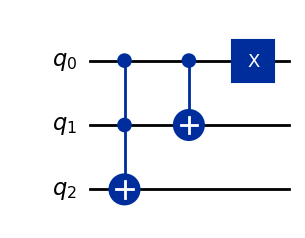

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [3]:
n = 3
v = [0, 3, 5, 6]
norm_factor = 1/sqrt(len(v))

# Codifica el vector como una superposición de estados base
e_inicial = norm_factor*Statevector.from_int(v[0], dims=2**n)
for i in v[1:]:
  e_inicial += norm_factor*Statevector.from_int(i, dims=2**n)

# Circuito suma 1 simple
qc = QuantumCircuit(n)
qc.ccx(0,1,2)
qc.cx(0,1)
qc.x(0)

display(qc.draw('mpl'))

# Evoluciona el estado inicial sobre el circuito
e_final = e_inicial.evolve(qc)

display(e_inicial.draw('latex', prefix = '|ei\\rangle = '))
display(e_final.draw('latex', prefix = '|ei\\rangle = '))



---



#### Oráculos cuánticos

Función de "caja negra" de la que solo podemos conocer su salida dada una entrada.

Los primeros algoritmos que veremos permiten extraer propiedades de un oráculo.


-------------------------------
-------------------------------
-------------------------------

# **Algoritmos "simples"**<a name="simples"></a>

Algoritmos que muestran ventaja sobre sus versiones clásicas.

## Algoritmo de Deutsch <a id="deutsch"></a>

Sea una función oráculo $f(x): \{0,1\}\rightarrow\{0,1\}$. Esta función se denomina:

- Constante: si $f(0)=f(1)$
- Balanceada: si $f(0)\ne f(1)$

Solo hay 4 funciones de este tipo:

<center><img src="https://drive.google.com/uc?export=view&id=1k5miZdzWjNI-3QBhNfq4zCtMzeo2zJeS" alt="Oraculos 1 bit" width="600"  /></center>

Las dos primeras ($f_0(x) = x$ y $f_1(x)=\bar x$) son balanceadas y las dos siguientes ($f_2(x) = 0$ y $f_3(x)=1$) son constantes.

Dada una de estas funciones $f(x)$ desconocida, un algoritmo clásico necesita 2 llamadas al oráculo $f$ para determinar si es constante o balanceada.

El **algoritmo cuántico de Deutsch** puede determinarlo con una sola llamada al oráculo $f$.

Partimos del circuito siguiente:


<center><img src="https://drive.google.com/uc?export=view&id=1aTCW5wZ3_UDNttVgWqC7igp5EyEDf1Em" alt="Deutsch" width="600"  /></center>


Estado después de la puerta X:
$$
|\psi_0\rangle = |10\rangle
$$

Estado despues de las H:
$$
|\psi_1\rangle = |-+\rangle = \frac{|0\rangle - |1\rangle}{\sqrt{2}}\otimes \frac{|0\rangle + |1\rangle}{\sqrt{2}} = |y\rangle \otimes|x\rangle
$$

Y se tiene que:

$$
y\oplus f(x) = \frac{|0\rangle - |1\rangle}{\sqrt{2}}\oplus f(x) = \frac{|0\oplus f(x)\rangle - |1\oplus f(x)\rangle}{\sqrt{2}} =
\begin{cases}
\frac{|0\rangle - |1\rangle}{\sqrt{2}}, & \text{si } f(x) = 0\\
\frac{|1\rangle - |0\rangle}{\sqrt{2}}, & \text{si } f(x) = 1
\end{cases}
$$

por lo que podemos escribir:
$$
y\oplus f(x) = (-1)^{f(x)}\frac{|0\rangle - |1\rangle}{\sqrt{2}}
$$

De aquí se tiene que:

$$
|\psi_2\rangle = \frac{1}{\sqrt{2}}(-1)^{f(x)} (|0\rangle - |1\rangle)\otimes |x\rangle =
\frac{1}{\sqrt{2}} (|0\rangle - |1\rangle)\otimes (-1)^{f(x)}|x\rangle
$$
Y podemos escribir:
$$
(-1)^{f(x)}|x\rangle = |(-1)^{f(x)}x\rangle =
\frac{(-1)^{f(0)}|0\rangle + (-1)^{f(1)}|1\rangle}{\sqrt{2}}
$$

Por lo tanto, el estado $|\psi_2\rangle$ queda:
$$
|\psi_2\rangle =
\frac{|0\rangle - |1\rangle}{\sqrt{2}}\otimes
\frac{(-1)^{f(0)}|0\rangle + (-1)^{f(1)}|1\rangle}{\sqrt{2}} =
\begin{cases}
\pm\left[\frac{|0\rangle - |1\rangle}{\sqrt{2}}\right] \otimes \left[\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right], & \text{si } f(0) = f(1)\\\mbox{}\\
\pm\left[\frac{|0\rangle - |1\rangle}{\sqrt{2}}\right] \otimes  \left[\frac{|0\rangle - |1\rangle}{\sqrt{2}}\right], & \text{si } f(0) \neq f(1)
\end{cases}
$$

Al aplicar la última `H`:

$$
|\psi_3\rangle =
\begin{cases}
\pm\frac{|0\rangle - |1\rangle}{\sqrt{2}} \otimes |0\rangle, & \text{si } f(0) = f(1)\\\mbox{}\\
\pm\frac{|0\rangle - |1\rangle}{\sqrt{2}} \otimes |1\rangle, & \text{si } f(0) \neq f(1)
\end{cases}
$$

Midiendo el cúbit de arriba vamos a obtener, con total certeza, un $0$ si $f$ es constante o un $1$ si $f$ es balanceada, con una sola evaluacion de $f(x)$.

#### **Implementación de los oráculos de Deutsch**

El circuito reversible $U_f$ para la función oráculo $f_0(x)=x$ se puede implementar con una puerta CNOT:


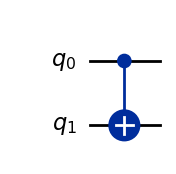

In [4]:
qc = QuantumCircuit(2)
# Aplica CNOT, primer parámetro target, segundo control
qc.cx(0,1)
qc.draw('mpl')

Qiskit permite expresar este circuito como una puerta que se puede integrar en un circuito mayor:

In [5]:
# Oráculo para f_0(x)=x
def f0_oraculo():
    """
    Define un oráculo para la funcion f0
        return: circuito de 2 cúbit en forma de puerta
    """
    qc = QuantumCircuit(2)
    # Aplica CNOT, primer parámetro target, segundo control
    qc.cx(0,1)

    # Convierte el circuito en una puerta
    oraculo = qc.to_gate()
    oraculo.name = "$U_{f_0}$"
    return oraculo

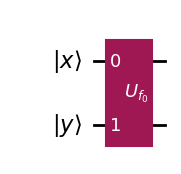

In [6]:
# Creamos un circuito y le añadimos el oráculo
# QuantumRegister: define registros de cúbits
x = QuantumRegister(1, name="|x\\rangle")
y = QuantumRegister(1, name="|y\\rangle")
qc = QuantumCircuit(x,y)

# Añadimos el oráculo
qc = qc.compose(f0_oraculo())

display(qc.draw('mpl'))

Los oráculos para las otras tres funciones son:

In [7]:
# Oraculo para f1(x)=^x
def f1_oraculo():
    """
    Define un oráculo para la funcion f1
        return: circuito de 2 cúbit en forma de puerta
    """
    qc = QuantumCircuit(2)
    # Lo mismo que f_0 pero inviertiendo la x antes de la CNOT
    qc.x(0)
    qc.cx(0,1)
    # Volvemos a invertir la x para recuperar su valor
    qc.x(0)

    # Convierte el circuito en una puerta
    oraculo = qc.to_gate()
    oraculo.name = "$U_{f_1}$"
    return oraculo

In [8]:
# Oráculo para f_2(x) = 0
def f2_oraculo():
    """
    Define un oráculo para la funcion f1
        return: circuito de 2 cúbit en forma de puerta
    """
    qc = QuantumCircuit(2)

    # El bit de ancilla siempre tiene que dar 0
    # no necesitamos hacer nada

    # Convierte el circuito en una puerta
    oraculo = qc.to_gate()
    oraculo.name = "$U_{f_2}$"
    return oraculo

In [9]:
# Oraculo para f_3(x) = 1
def f3_oraculo():
    """
    Define un oráculo para la funcion f3
        return: circuito de 2 cúbit en forma de puerta
    """
    qc = QuantumCircuit(2)

    # Invertimos el cúbit de ancilla para que siempre de 1
    qc.x(1)

    # Convierte el circuito en una puerta
    oraculo = qc.to_gate()
    oraculo.name = "$U_{f_3}$"
    return oraculo

### Ejercicio: Deutsch

Implementa un circuito en Qiskit para probar el algoritmo de Deutsch con los oráculos definidos para las funciones anteriores. Comprueba que es capaz de determinar si la función es constante o balanceada.

In [ ]:
# Empieza creando un circuito a partir de un oráculo
def deutsch_qc(oraculo):
    x = QuantumRegister(1, name="|x\\rangle")
    y = QuantumRegister(1, name="|y\\rangle")
    meas = ClassicalRegister(1, name="Medida")
    qc = ....

    # Añade las puertas iniciales
    qc....
    qc....
    qc....

    # Añade el oraculo
    qc = qc.compose(oraculo())

    # Añade la última puerta H
    qc....

    # Añade la medida
    qc....

    return qc

In [ ]:
# Probamos con f0
qc = deutsch_qc(f0_oraculo)
qc.draw('mpl', style="iqp")

In [15]:
# Hacemos la simulacion
sim = AerSimulator()
result = sim.run(qc, shots=1024).result()
plot_histogram(result.get_counts())

AerError: 'unknown instruction: $U_{f_0}$'

In [ ]:
# Probamos con las otras 3
for f in [f1_oraculo, f2_oraculo, f3_oraculo]:
    qc = deutsch_qc(f)
    # hacemos la simulacion
    result = sim.run(qc, shots=1000).result()
    display(plot_histogram(result.get_counts()))



---




## Algoritmo de Deutsch-Jozsa <a name="dj"></a>

Es una generalización a $n$ bits del anterior. Dada una función (oráculo) $f(\{x_{n-1},x_{n-2},\ldots,x_1,x_{0}\}) \rightarrow \{0,1\}$, que es, o bien, _balanceada_, o bien, _constante_, determinar el tipo:

- Función constante: la salida de $f(x)$ es, o bien, 0, o bien, 1 $\forall x$
- Función balanceada: devuelve 0 para la mitad de las entradas y 1 para la otra mitad

**Solución clásica**

Un algoritmo clásico necesita efectuar en el mejor caso $2$ y en el peor $2^{n-1}+1$ evaluaciones de $f(x)$, por lo que su complejidad es exponencial $\mathcal{O}(2^n)$.

**Solución cuántica**

El algoritmo cuántico ([D. Deutsch and R. Jozsa, 1992](https://doi.org/10.1098%2Frspa.1992.0167)) solo necesita una evaluación del oráculo $f(x)$ (ganancia exponencial).

El circuito usado es:

<center><img src="https://drive.google.com/uc?export=view&id=15N7Y3uoVXhbW2yMbUJlYljrhbii4EqkL" alt="Deutsch-Jozsa" width="700"  /></center>

Si la medida devuelte todo 0, 𝑓 es constante. Si obtenemos cualquier otro valor 𝑓 es balanceada.

<details>
<summary>Demostración del algoritmo de Deutsch-Jozsa</summary>
Pasos:

<ol>
   <li>
        Estado inicial:
        

$$\vert \psi_0 \rangle = \vert 1\rangle \vert0\rangle^{\otimes n} $$


   </li>
    
   <li>
        Después de aplicar las primeras puertas H:
$$\vert \psi_1 \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \left(|0\rangle - |1 \rangle \right)\vert x\rangle $$
   </li>
   <p>
   <li>
        Aplicamos $U_f$ a $\vert y\rangle \vert x\rangle$ para obtener $\vert y \oplus f(x)\rangle\vert x\rangle$, recordando que $y\oplus f(x) = \tfrac{1}{\sqrt{2}} (-1)^{f(x)}(|0\rangle - |1\rangle)$:

$$\vert\psi_2\rangle  = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}(|0\rangle - |1\rangle)|x\rangle=\frac{(|0\rangle - |1\rangle)}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}|x\rangle$$
          </li>
<p>
<li>Ahora aplicamos una H a cada cúbit en  $|x\rangle$ (recordemos que $H^{\otimes n}|x\rangle = \tfrac{1}{\sqrt{2^n}} \sum_{i=0}^{2^n-1} (-1)^{x\cdot i}|i\rangle)$. Si ya no consideramos el cúbit de abajo, el estado es:<p>
$$
\begin{aligned}
    \lvert \psi_3 \rangle
        & = \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)}
            \left[ \sum_{i=0}^{2^n-1}(-1)^{x \cdot i}
            \vert i \rangle \right] \\
        & = \frac{1}{2^n}\sum_{i=0}^{2^n-1}
            \left[ \sum_{x=0}^{2^n-1}(-1)^{f(x)}(-1)^{x \cdot i} \right]
            \vert i \rangle
\end{aligned}
$$
       
con $x \cdot i = x_{n-1}i_{n-1}\oplus x_{n-2}i_{n-2}\oplus \ldots \oplus x_1i_1 \oplus x_0i_0$.
   </li>

   <li>

Se realiza la medida. La probabilidad de obtener todo 0 ($\vert i \rangle=  \vert 0 \rangle ^{\otimes n}$) es:
$$
\left| \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)} \right|^2 =
\begin{cases}
1, \text{si } f \text{ es constante}\\
0, \text{si } f \text{ es balanceada}
\end{cases}
$$

   </li>
<p>
</ol>

En conclusión, si a la salida obtenemos todo 0, $f$ es constante. Si obtenemos cualquier otro valor $f$ es balanceada.

**Ejemplo**
Supongamos $n=2$. Las probabilidades asociadas a cada salida son:

$$
p(0) = \left|\frac{1}{4} \sum_{x=0}^{3}(-1)^{f(x)}(-1)^{x \cdot 0} \right|^2 = \left|\frac{1}{4} \left[ (-1)^{f(0)}(-1)^{0} + (-1)^{f(1)}(-1)^{0} + (-1)^{f(2)}(-1)^{0} + (-1)^{f(3)}(-1)^{0}\right]  \right|^2
$$
$$
p(1) = \left|\frac{1}{4} \sum_{x=0}^{3}(-1)^{f(x)}(-1)^{x \cdot 1} \right|^2 = \left|\frac{1}{4} \left[ (-1)^{f(0)}(-1)^{0} + (-1)^{f(1)}(-1)^{1} + (-1)^{f(2)}(-1)^{0} + (-1)^{f(3)}(-1)^{1}\right]  \right|^2
$$
$$
p(2) = \left|\frac{1}{4} \sum_{x=0}^{3}(-1)^{f(x)}(-1)^{x \cdot 2} \right|^2 = \left|\frac{1}{4} \left[ (-1)^{f(0)}(-1)^{0} + (-1)^{f(1)}(-1)^{0} + (-1)^{f(2)}(-1)^{1} + (-1)^{f(3)}(-1)^{1}\right]  \right|^2
$$
$$
p(3) = \left|\frac{1}{4} \sum_{x=0}^{3}(-1)^{f(x)}(-1)^{x \cdot 3} \right|^2 = \left|\frac{1}{4} \left[ (-1)^{f(0)}(-1)^{0} + (-1)^{f(1)}(-1)^{1} + (-1)^{f(2)}(-1)^{1} + (-1)^{f(3)}(-1)^{0}\right]  \right|^2
$$

Es fácil ver que si $f$ es constante, $p(0)=1$ y $p(1)=p(2)=p(3)=0$, ya que se anulan los términos. Por contra, si $f$ es balanceada $p(0)=0$.

</details>




---

**Ejemplo: Oráculo balanceado de $n$ bits**



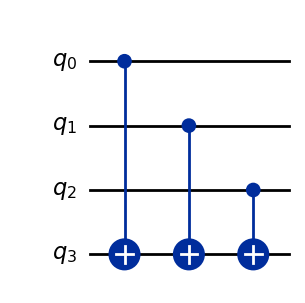

In [19]:
n = 3
# x: n cubits de entrada, f(x) 1 cubit de salida
oraculo_bal = QuantumCircuit(n+1)

for q in range(n):
    oraculo_bal.cx(q,n)

oraculo_bal.draw('mpl')

Si $|q_2q_1q_0\rangle$ tiene paridad par devuelve un 1, en caso contrario un 0.

Expresado en forma de función:

In [49]:
# Oráculo balanceado
def bal_oraculo(n):
    """
    Define un oraculo balanceado de n bits
        return: circuito de 2 cúbit en forma de puerta
    """
    qc = QuantumCircuit(n+1)

    # Aplica CNOTs
    qc.cx(range(n),n)

    # Convierte el circuito en una puerta
    oraculo = qc.to_gate()
    oraculo.name = "$U_{bal}$"
    return oraculo

El caso de un oráculo constantes es trivial:

In [50]:
# Oráculo constante
def cte_oraculo(n):
    """
    Define un oraculo balanceado de n bits
        return: circuito de 2 cúbit en forma de puerta
    """
    qc = QuantumCircuit(n+1)

    # Puerta identidad

    # Convierte el circuito en una puerta
    oraculo = qc.to_gate()
    oraculo.name = "$U_{cte}$"
    return oraculo


---

**Ejemplo: Circuito para Deutsch-Jozsa**

Es idéntico al de Deutsch pero con $|x\rangle$ de $n$ bits.

In [52]:
# Especificando el nº de cúbits y el oráculo
def dj_qc(n, oraculo):
    x = QuantumRegister(n, name="|x\\rangle")
    y = QuantumRegister(1, name="|y\\rangle")
    meas = ClassicalRegister(n, name="Medida")
    qc = QuantumCircuit(x,y,meas)

    # Añade las puertas iniciales
    qc.x(y)
    qc.h(x)
    qc.h(y)

    # Añade el oraculo
    qc = qc.compose(oraculo(n))

    # Añade la última puerta H
    qc.h(x)

    # Añade la medida
    qc.measure(x,meas)

    return qc

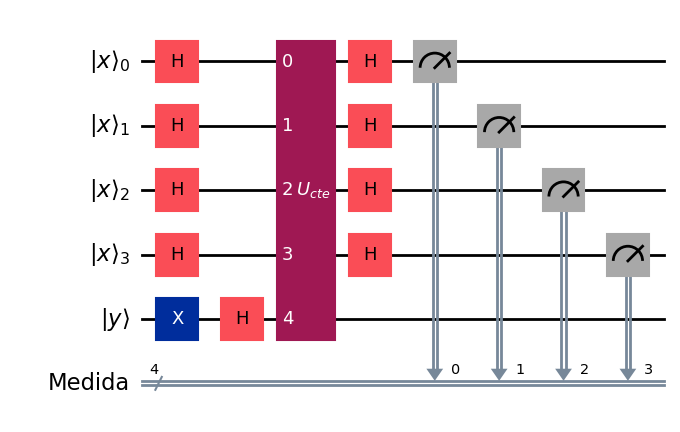

In [53]:
# Probamos con un oráculo constante
n = 4
qc = dj_qc(n, cte_oraculo)
qc.draw('mpl')

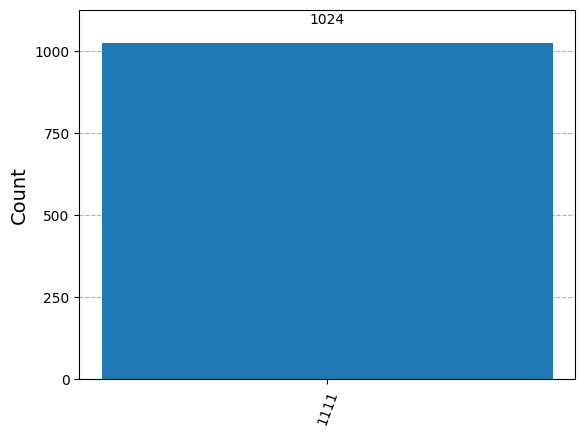

In [56]:
# Utilizamos el simulador Aer por defecto
sim = AerSimulator(method='automatic')

# Tenemos que "transpilar" el código al simulador
qc_obj = transpile(qc,sim)
# Hacemos una simulación y obtenemos los resultados
result = sim.run(qc_obj, shots=1024).result()

plot_histogram(result.get_counts())

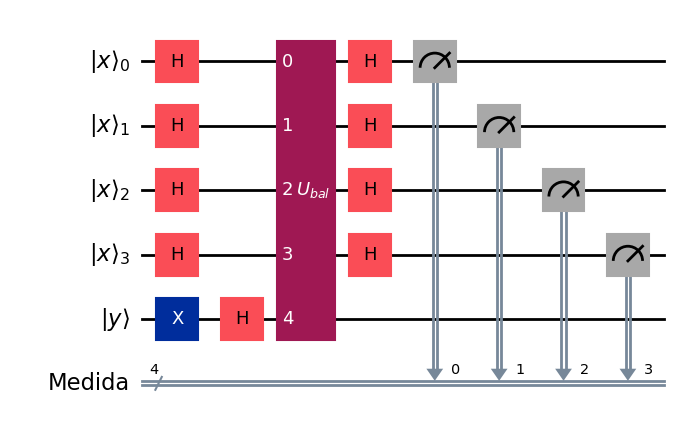

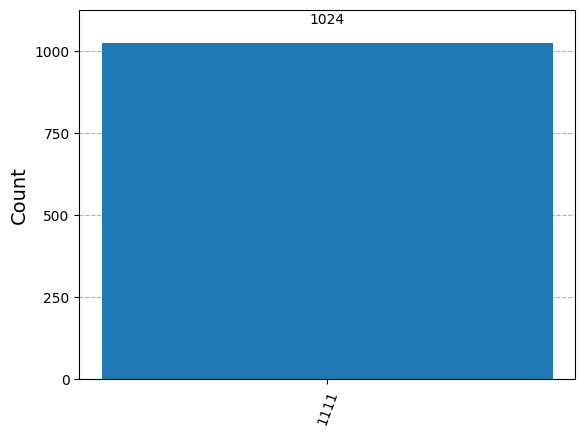

In [57]:
# Probamos con un oráculo balanceado
n = 4
qc = dj_qc(n, bal_oraculo)
display(qc.draw('mpl'))

# Medimos y mostramos el histograma
# Hacemos la simulacion
result = sim.run(transpile(qc,sim),shots=1024).result()
salida = result.get_counts()
plot_histogram(salida)

-----------------------

## Algoritmo de Bernstein-Vazirani <a name="bv"></a>

Es una versión del anterior en la que el oráculo $f(\{x_{n-1},x_{n-2},\ldots,x_{0}\}) \rightarrow \{0,1\}$ es de la forma $f_s(x) = s\cdot x = s_{n-1}x_{n-1} \oplus s_{n-2}x_{n-2} \oplus \ldots \oplus s_{0}x_{0}$, con $s_i\in\{0,1\}$, donde $s$ es desconocido. El objetivo es encontrar el valor de $s$.

**Solución clásica**

Para obtener $s$, un algoritmo clásico tiene que hacer $n$ invocaciones de $f_s(x)$ con los valores $x=2^i$ con $i \in \{0,\ldots,n-1\}$.

$$
s_0 = f_s(000\ldots 01)\\
s_1 = f_s(000\ldots 10)\\
\cdots\\
s_{n-1} = f_s(100\ldots 00)
$$

**Solución cuántica**

El algoritmo cuántico ([E. Bernstein y U. Vazirani, 1997](https://doi.org/10.1137/S0097539796300921)) necesita 1 sola invocación del oráculo. La salida del circuito es el estado $|s\rangle$.

El circuito es idéntico al de Deutsch-Jozsa, solo cambia la función oráculo.

<details>
<summary>Demostración del algoritmo de Bernstein-Vazirani</summary>

Al igual que antes tenemos:

$$            
\lvert \psi_3 \rangle  = \frac{1}{2^n}\sum_{i=0}^{2^n-1}
                    \left[ \sum_{x=0}^{2^n-1}(-1)^{f_s(x)}(-1)^{x \cdot i} \right]
                    \vert i \rangle =
                    \frac{1}{2^n}\sum_{i=0}^{2^n-1}
                    \left[ \sum_{x=0}^{2^n-1}(-1)^{s\cdot x}(-1)^{x \cdot i} \right]
                    \vert i \rangle =
                    \sum_{i=0}^{2^n-1}
                    \left[ \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{s\cdot x}(-1)^{x \cdot i} \right]
$$

El sumatorio sobre $x$ se puede escribir:

$$
\frac{1}{2^n} \sum_{x=0}^{2^n-1}(-1)^{s\cdot x}(-1)^{x \cdot i} = \frac{1}{2^n} \sum_{x=0}^{2^n-1}(-1)^{(s\cdot x) \oplus (x \cdot i)} = \frac{1}{2^n} \sum_{x=0}^{2^n-1}(-1)^{(s \oplus i)\cdot x}
=
       \begin{cases}
       1, \text{si } s \oplus i = 0\\
       0, \text{si } s \oplus i = 1
       \end{cases}
$$                    

Y $s \oplus i = 0 \Rightarrow s = i$, es decir, que la amplitud no nula es, precisamente, $|s\rangle$.

**Ejemplo**: supongamos $n=2$. Aplicando el algoritmo tenemos en el paso 2:

$$
\lvert \psi_2 \rangle  
    = \frac{|0\rangle - |1\rangle}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}|x\rangle
    = \frac{|0\rangle - |1\rangle}{2\sqrt{2}}
                 \left[
                 (-1)^{s\cdot 00}|00\rangle +
                 (-1)^{s\cdot 01}|01\rangle +
                 (-1)^{s\cdot 10}|10\rangle +
                 (-1)^{s\cdot 11}|11\rangle\right]
$$

Si suponemos $s=11$, el estado será:

$$
\lvert \psi_2 \rangle =   \frac{|0\rangle - |1\rangle}{2\sqrt{2}}
                 \left[
                 (-1)^{11\cdot 00}|00\rangle +
                 (-1)^{11\cdot 01}|01\rangle +
                 (-1)^{11\cdot 10}|10\rangle +
                 (-1)^{11\cdot 11}|11\rangle\right] =
                 \frac{1}{2}(|00\rangle - |01\rangle - |10\rangle + |11\rangle)
$$

Y al aplicar las `H`:

$$
\lvert \psi_3 \rangle =   \frac{1}{4}\left[
(|0\rangle+|1\rangle)\otimes(|0\rangle+|1\rangle) -
(|0\rangle+|1\rangle)\otimes(|0\rangle-|1\rangle) -
(|0\rangle-|1\rangle)\otimes(|0\rangle+|1\rangle) +
(|0\rangle-|1\rangle)\otimes(|0\rangle-|1\rangle)
\right] = \\
= \frac{1}{4}\left[
|00\rangle + |01\rangle + |10\rangle + |11\rangle - |00\rangle + |01\rangle - |10\rangle + |11\rangle  
- |00\rangle - |01\rangle + |10\rangle + |11\rangle + |00\rangle - |01\rangle - |10\rangle + |11\rangle
\right] = \\
= |11\rangle = |s\rangle
$$

</details>


------------------------------

## Algoritmo de periodicidad de Simon <a name="simon"></a>

En este caso, el oráculo es una función $f_c:\{0,1\}^n \rightarrow \{0,1\}^n$ que depende de un número binario desconocido $c=c_{n-1}c_{n-2}\ldots c_0 \ne 0$, con $c_i \in \{0,1\}$, tal que, para todos los valores $x,y \in \{0,1\}^n$ se tiene que:
$$
f_c(x) = f_c(y) \Leftrightarrow y=x\oplus c \text{   (o que }x\oplus y =c\text{)}
$$

Es decir, los valores de $f_c$ se repiten con un cierto patrón dado por $c$, que se denomina período. Por ejemplo, supongamos $n=3$ y $c=5\equiv 101$:

$$
\hphantom{00} x\hphantom{0 \oplus 1} c \hphantom{01 = 1} y\hphantom{01 \Rightarrow f_c(0) = f_c(5)}\\
000 \oplus 101 = 101 \Rightarrow f_c(0) = f_c(5)\\
001 \oplus 101 = 100 \Rightarrow f_c(1) = f_c(4)\\
010 \oplus 101 = 111 \Rightarrow f_c(2) = f_c(7)\\
011 \oplus 101 = 110 \Rightarrow f_c(3) = f_c(6)\\
100 \oplus 101 = 001 \Rightarrow f_c(4) = f_c(1)\\
101 \oplus 101 = 000 \Rightarrow f_c(5) = f_c(0)\\
110 \oplus 101 = 011 \Rightarrow f_c(6) = f_c(3)\\
111 \oplus 101 = 010 \Rightarrow f_c(7) = f_c(2)
$$

**Solución clásica**

Un algoritmo clásico necesita evaluar la función hasta encontrar dos valores $x$ e $y$ tales que $f_c(x) = f_c(y)$. Dados esos valores, se tiene que $c=x\oplus y$.

En el peor de los casos tenemos que buscar en la mitad de los valores, efectuando $2^{n-1}+1$ evaluaciones de $f(x)$.

**Solución cuántica**

El algoritmo cuántico ([D. R. Simon, 1997](https://doi.org/10.1137/S0097539796298637)) solo necesita $\mathcal{O}(n)$ evaluaciones.

El circuito que se utiliza es similar al que venimos usando pero con $n$ bits de ancilla:

<center><img src="https://drive.google.com/uc?export=view&id=1kVEdsa1Bg8CgH_UOelGFPTzt9vp88hbr" alt="Simon" width="700"  /></center>

La salida del algoritmo es un estado $|i\rangle = |i_{n-1}\ldots i_0\rangle$ que verifica que $c \cdot i = c_{n-1}\cdot i_{n-1}\oplus c_{n-2}\cdot i_{n-2}\oplus \ldots\oplus c_0\cdot i_0 = 0$.

Midiendo $\mathcal{O(n)}$ veces obtenemos conjunto de ecuaciones que permiten calcular el valor de $c$.

---

**Ejemplo**

Usamos el algoritmo de Simon para $n=3$ y obtenemos a la salida los siguientes estados: $|000\rangle$, $|001\rangle$, $|110\rangle$ y $|111\rangle$. ¿Cuánto vale $c$?

i. $|000\rangle\cdot c = 0\cdot c_2\oplus 0\cdot c_1 \oplus 0\cdot c_0 = 0$

ii. $|001\rangle\cdot c = 0\cdot c_2\oplus 0\cdot c_1 \oplus 1\cdot c_0 = 0$

iii. $|110\rangle\cdot c = 1\cdot c_2\oplus 1\cdot c_1 \oplus 0\cdot c_0 = 0$

iv. $|111\rangle\cdot c = 1\cdot c_2\oplus 1\cdot c_1 \oplus 1\cdot c_0 = 0$

la ecuación (ii) indica que $c_0 = 0$ y la (iii) y la (iv) que $c_2\oplus c_1 =0$. Las únicas opciones para $c$ son $000$ o $110$, y como $c\neq 0$, tenemos que $c=6$.

---

<details>
<summary>Demostración del algoritmo de Simon</summary>
Pasos:

<ol>
   <li>
Estado inicial:
        

$$\vert \psi_0 \rangle = \vert0\rangle^{\otimes n} \vert 0\rangle^{\otimes n}$$


   </li>
    
   <li>
Después de aplicar las primeras puertas H:
$$\vert \psi_1 \rangle = \frac{1}{\sqrt{2^n}}\sum_{x=0}^{2^n-1}|0\rangle \vert x\rangle$$
   </li>
   <p>
   <li>
Aplicamos $U_f$ a $\vert y\rangle\vert x\rangle$ para obtener $\vert y \oplus f(x)\rangle\vert x\rangle$:
$$
\lvert \psi_2 \rangle  
= \frac{1}{\sqrt{2^n}}\sum_{x=0}^{2^n-1}|0\oplus f(x)\rangle|x\rangle =  
\frac{1}{\sqrt{2^n}}\sum_{x=0}^{2^n-1}|f(x)\rangle|x\rangle
$$
          </li>
<p>
   <li>Ahora aplicamos una H a cada cúbit en  $|x\rangle$ (recordemos que $H^{\otimes n}|x\rangle = \frac{1}{\sqrt{2^n}} \sum_{i=0}^{2^n-1} (-1)^{x\cdot i}|i\rangle)$<p>
$$
\begin{aligned}
    \lvert \psi_3 \rangle
          = \frac{1}{2^n} \sum_{x=0}^{2^n-1}|f(x)\rangle \sum_{i=0}^{2^n-1}(-1)^{x \cdot i} \vert i \rangle
          = \frac{1}{2^n}\sum_{x=0}^{2^n-1}
            \left[ \sum_{i=0}^{2^n-1}(-1)^{x \cdot i}
            \vert f(x) \rangle \vert i \rangle \right]
\end{aligned}
$$
          </li><br>
</ol>

Sabemos que para cada $\vert x \rangle$ y para cada $\vert i \rangle$ se verifica que $\vert f(x) \rangle\vert i \rangle = \vert f(x\oplus c) \rangle\vert i \rangle$. Para un par de este tipo, los sumandos son:

$$
\frac{(-1)^{x \cdot i} + (-1)^{(x\oplus c) \cdot i}}{2^n}\vert f(x) \rangle\vert i \rangle =
\frac{(-1)^{x \cdot i} + (-1)^{(x\cdot i)\oplus (c\cdot i)}}{2^n}\vert f(x)\rangle\vert i\rangle =
\frac{(-1)^{x \cdot i}[1+(-1)^{c \cdot i}]}{2^n}\vert f(x)\rangle\vert i\rangle
$$

Así, si $c \cdot i = 1$ el termino correspondiente a $\vert f(x)\rangle\vert i\rangle$ se anula, y solo quedan los terminos para los que $c \cdot i = 0$.

Repitiendo varias veces la medida, podemos encontrar diferentes valores de $|i\rangle$ y, a partir de esas ecuaciones, obtener $c$.

**Ejemplo**

Supongamos $f:\{0,1\}^3 \rightarrow \{0,1\}^3$ tal que:
$$
f(0) = f(5) = 4\\
f(1) = f(4) = 1\\
f(2) = f(7) = 5\\
f(3) = f(6) = 7
$$

Es fácil comprobar que $f$ cumple los requisitos para aplicar el algoritmo de Simon.

Aplicando los pasos anteriores, en el paso 3 tenemos:

   
       
$$
\lvert \psi_3 \rangle
                 = \frac{1}{8}\sum_{x=0}^{7}
                    \sum_{i=0}^{7}(-1)^{x \cdot i}
                    \vert f(x)\rangle\vert i\rangle =
                    \frac{1}{8}[\\
|f(0)\rangle|0\rangle +  |f(0)\rangle|1\rangle +  |f(0)\rangle|2\rangle +  |f(0)\rangle|3\rangle + \\
|f(0)\rangle|4\rangle +  |f(0)\rangle|5\rangle +  |f(0)\rangle|6\rangle +  |f(0)\rangle|7\rangle +\\[5pt]
|f(1)\rangle|0\rangle -  |f(1)\rangle|1\rangle +  |f(1)\rangle|2\rangle -  |f(1)\rangle|3\rangle + \\
|f(1)\rangle|4\rangle -  |f(1)\rangle|5\rangle +  |f(1)\rangle|6\rangle -  |f(1)\rangle|7\rangle +\\[5pt]
|f(2)\rangle|0\rangle +  |f(2)\rangle|1\rangle -  |f(2)\rangle|2\rangle -  |f(2)\rangle|3\rangle + \\
|f(2)\rangle|4\rangle +  |f(2)\rangle|5\rangle -  |f(2)\rangle|6\rangle -  |f(2)\rangle|7\rangle +\\[5pt]
|f(3)\rangle|0\rangle -  |f(3)\rangle|1\rangle -  |f(3)\rangle|2\rangle +  |f(3)\rangle|3\rangle + \\
|f(3)\rangle|4\rangle -  |f(3)\rangle|5\rangle -  |f(3)\rangle|6\rangle +  |f(3)\rangle|7\rangle +\\[5pt]
|f(4)\rangle|0\rangle +  |f(4)\rangle|1\rangle +  |f(4)\rangle|2\rangle +  |f(4)\rangle|3\rangle - \\
|f(4)\rangle|4\rangle -  |f(4)\rangle|5\rangle -  |f(4)\rangle|6\rangle -  |f(4)\rangle|7\rangle +\\[5pt]
|f(5)\rangle|0\rangle -  |f(5)\rangle|1\rangle +  |f(5)\rangle|2\rangle -  |f(5)\rangle|3\rangle - \\
|f(5)\rangle|4\rangle +  |f(5)\rangle|5\rangle -  |f(5)\rangle|6\rangle +  |f(5)\rangle|7\rangle +\\[5pt]
|f(6)\rangle|0\rangle +  |f(6)\rangle|1\rangle -  |f(6)\rangle|2\rangle -  |f(6)\rangle|3\rangle - \\
|f(6)\rangle|4\rangle -  |f(6)\rangle|5\rangle +  |f(6)\rangle|6\rangle +  |f(6)\rangle|7\rangle +\\[5pt]
|f(7)\rangle|0\rangle -  |f(7)\rangle|1\rangle -  |f(7)\rangle|2\rangle +  |f(7)\rangle|3\rangle - \\
|f(7)\rangle|4\rangle +  |f(7)\rangle|5\rangle +  |f(7)\rangle|6\rangle -  |f(7)\rangle|7\rangle\ ]
$$

Substituyendo los valores de $f$:

$$
\lvert \psi_3 \rangle = \frac{1}{8}[\\
|4\rangle|0\rangle +  |4\rangle|1\rangle +  |4\rangle|2\rangle +  |4\rangle|3\rangle +  
|4\rangle|4\rangle +  |4\rangle|5\rangle +  |4\rangle|6\rangle +  |4\rangle|7\rangle +\\[5pt]
|1\rangle|0\rangle -  |1\rangle|1\rangle +  |1\rangle|2\rangle -  |1\rangle|3\rangle +  
|1\rangle|4\rangle -  |1\rangle|5\rangle +  |1\rangle|6\rangle -  |1\rangle|7\rangle +\\[5pt]
|5\rangle|0\rangle +  |5\rangle|1\rangle -  |5\rangle|2\rangle -  |5\rangle|3\rangle +  
|5\rangle|4\rangle +  |5\rangle|5\rangle -  |5\rangle|6\rangle -  |5\rangle|7\rangle +\\[5pt]
|7\rangle|0\rangle -  |7\rangle|1\rangle -  |7\rangle|2\rangle +  |7\rangle|3\rangle +  
|7\rangle|4\rangle -  |7\rangle|5\rangle -  |7\rangle|6\rangle +  |7\rangle|7\rangle +\\[5pt]
|1\rangle|0\rangle +  |1\rangle|1\rangle +  |1\rangle|2\rangle +  |1\rangle|3\rangle -  
|1\rangle|4\rangle -  |1\rangle|5\rangle -  |1\rangle|6\rangle -  |1\rangle|7\rangle +\\[5pt]
|4\rangle|0\rangle -  |4\rangle|1\rangle +  |4\rangle|2\rangle -  |4\rangle|3\rangle -  
|4\rangle|4\rangle +  |4\rangle|5\rangle -  |4\rangle|6\rangle +  |4\rangle|7\rangle +\\[5pt]
|7\rangle|0\rangle +  |7\rangle|1\rangle -  |7\rangle|2\rangle -  |7\rangle|3\rangle -  
|7\rangle|4\rangle -  |7\rangle|5\rangle +  |7\rangle|6\rangle +  |7\rangle|7\rangle +\\[5pt]
|5\rangle|0\rangle -  |5\rangle|1\rangle -  |5\rangle|2\rangle +  |5\rangle|3\rangle -  
|5\rangle|4\rangle +  |5\rangle|5\rangle +  |5\rangle|6\rangle -  |5\rangle|7\rangle\ ]
$$

Simplificando:
$$
\lvert \psi_3 \rangle = \frac{1}{4}\left[\\
|4\rangle|0\rangle+|1\rangle|0\rangle+|5\rangle|0\rangle+|7\rangle|0\rangle+\\
|4\rangle|2\rangle+|1\rangle|2\rangle-|5\rangle|2\rangle-|7\rangle|2\rangle+\\
|4\rangle|5\rangle-|1\rangle|5\rangle+|5\rangle|5\rangle-|7\rangle|5\rangle+\\
|4\rangle|7\rangle-|1\rangle|7\rangle-|5\rangle|7\rangle+|7\rangle|7\rangle\ \right]
$$

Que podemos escribir como:
$$
\lvert \psi_3 \rangle = \frac{1}{4}\left[\\
(|4\rangle+|1\rangle+|5\rangle+|7\rangle) \otimes|0\rangle+\\
(|4\rangle+|1\rangle-|5\rangle-|7\rangle)\otimes|2\rangle+\\
(|4\rangle-|1\rangle+|5\rangle-|7\rangle)\otimes|5\rangle+\\
(|4\rangle-|1\rangle-|5\rangle+|7\rangle)\otimes|7\rangle\ \right]
$$

Al medir los 3 bits $|x\rangle$ obtenemos, con igual probabilidad, $|000\rangle$, $|010\rangle$, $|101\rangle$ o $|111\rangle$. Para esos valores, su producto bit a bit por $c$ (módulo 2) da 0, por lo que tenemos, si $c=c_2c_1c_0$, con $c_i\in \{0,1\}$, las siguientes ecuaciones:

i. $|000\rangle\cdot c = 0\cdot c_2\oplus 0\cdot c_1 \oplus 0\cdot c_0 = 0$

ii. $|010\rangle\cdot c = 0\cdot c_2\oplus 1\cdot c_1 \oplus 0\cdot c_0 = 0$

iii. $|101\rangle\cdot c = 1\cdot c_2\oplus 0\cdot c_1 \oplus 1\cdot c_0 = 0$

iv. $|111\rangle\cdot c = 1\cdot c_2\oplus 1\cdot c_1 \oplus 1\cdot c_0 = 0$

la ecuación (ii) indica que $c_1 = 0$, la (iii) que $c_2\oplus c_0 =0$ y la (iv) que $c_2\oplus c_1 \oplus c_0 =0$. Las únicas opciones para $c$ son $000$ o $101$, y como $c\neq 0$, tenemos que $c=5$.

</details>

-------------------------
--------------------
-------------------

# **Algoritmo de búsqueda de Grover: amplificación de amplitud** <a name="grover"></a>

Este algoritmo busca un dato en una lista no estructurada.

El oráculo $f:\{0,1\}^n \rightarrow \{0,1\}$ es tal que existe un único $x_i$ tal que:
$$
f(x) =
\begin{cases}
1, \text{si } x=x_i\\
0, \text{si } x\ne x_i
\end{cases}
$$

Buscamos $x_i$.

**Nota**: Es posible generalizar el algoritmo para cuando existe más de un dato $x_i$

**Solución clásica**

Si $N=2^n$ es el número de datos en la lista, un algoritmo clásico necesita efectuar, en el peor de los casos $N$ evaluaciones de $f(x)$, y de media $N/2$, por lo que la complejidad es $\mathcal{O}(2^n)$

**Solución cuántica**

El algoritmo cuántico ([L. K. Grover, 1996](http://doi.acm.org/10.1145/237814.237866)) solo necesita $\mathcal{O}\left(\sqrt{2^n}\right)$ evaluaciones.

El algoritmo tiene dos partes:

### Inversión de fase

En esta parte, se busca invertir el signo del cúbit $|x_i\rangle$, es decir, pasar de la superposición completa $\tfrac{1}{\sqrt{2^n}}\sum_{x=0}^{n-1}|x\rangle$ a:

$$
\frac{1}{\sqrt{2^{n}}}\left(\sum_{x\ne x_i}|x\rangle- |x_i\rangle\right)
$$

Un oráculo que implementa esta inversión es:

<center><img src="https://drive.google.com/uc?export=view&id=136kAs3r6LXcsBEONPH_j1Y_SnsqrsDVX" alt="Grover Inversión de fase" width="600"  /></center>

<details>
<summary>Demostración de la inversion de fase</summary>
Pasos:

<ol>
   <li>
        Estado inicial:
        

$$\vert \psi_0 \rangle =  \vert1\rangle\vert0\rangle^{\otimes n}$$


   </li>
    
   <li>
        Después de aplicar las primeras puertas H:
$$\vert \psi_1 \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} (|0\rangle-|1\rangle)\vert x\rangle $$
   </li>
   <p>
   <li>
        Aplicamos $U_f$ a $\vert y\rangle\vert x\rangle$ para obtener $\vert y \oplus f(x)\rangle\vert x\rangle$:
        $$
            \lvert \psi_2 \rangle  
                 = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(|0\oplus f(x)\rangle - |1\oplus f(x)\rangle)|x\rangle
        $$
          </li>
<p>
   <li>Como $f(x) = 1$ si $x = x_i$ y $f(x)=0$ en otro caso podemos escribir:
$$
\begin{aligned}
\lvert \psi_2 \rangle  
&= \frac{1}{\sqrt{2^{n+1}}}\left[\left(|0\oplus f(x_i)\rangle - |1\oplus f(x_i)\rangle\right)|x_i\rangle + \sum_{x\ne x_i}\left(|0\oplus f(x)\rangle - |1\oplus f(x)\rangle\right)|x\rangle\right] \\
&= \frac{1}{\sqrt{2^{n+1}}}\left[(|1\rangle - |0\rangle)|x_i\rangle + \sum_{x\ne x_i}\left(|0\rangle - |1\rangle\right)|x\rangle\right] \\
&= \frac{1}{\sqrt{2^{n+1}}}\left[\left(\sum_{x\ne x_i}\left(|0\rangle - |1\rangle\right)|x\rangle\right) - (|0\rangle - |1\rangle)|x_i\rangle\right] \\
&= \frac{|0\rangle - |1\rangle}{\sqrt{2}}\frac{\sum_{x\ne x_i}|x\rangle- |x_i\rangle}{\sqrt{2^{n}}}
\end{aligned}
$$  
          </li><br>
</ol>

El estado que medimos es, por lo tanto:

$$
\frac{\sum_{x\ne x_i}|x\rangle- |x_i\rangle}{\sqrt{2^{n}}}
$$

Vemos que el estado $|x_i\rangle$ aparece con signo negativo.
</details>

En la práctica, implementar esta inversión de fase puede hacerse de forma simple, sin necesidad de la ancilla.  

Supongamos que, con 2 cúbits, queremos invertir el estado $x_i = |10\rangle$:

1. Partimos de un estado en superposición

$$
\frac{|00\rangle + |01\rangle + |10\rangle + |11\rangle}{2}
$$

3. Aplicamos una puerta CZ entre los cúbits, que cambia el signo al estado $|11\rangle$

$$
\frac{|00\rangle + |01\rangle + |10\rangle - |11\rangle}{2}
$$
4. Invertimos los cúbits para los cuales hay un 0 en $x_i$:

$$
\frac{|01\rangle + |00\rangle + |11\rangle - |10\rangle}{2} =
\frac{|00\rangle + |01\rangle - |10\rangle + |11\rangle}{2}
$$

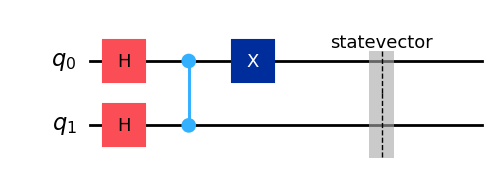

In [70]:
# Queremos invertir el estado |10>
n = 2
xi = 2 # 10 en binario

# Creamos el circuito
qc_pinv = QuantumCircuit(n)

# Ponemos los qbits en superposición
for q in range(n):
    qc_pinv.h(q)

# Aplico la puerta CZ
# El cambio de fase afecta a |11>
qc_pinv.cz(0,1)

# Invertimos los cubits para los que s tenga un bit a 0
temp = xi
for b in range(n):
    if(temp & 1 == 0):
        qc_pinv.x(b)
    temp >>= 1

qc_pinv.save_statevector()
qc_pinv.draw('mpl')

<IPython.core.display.Latex object>

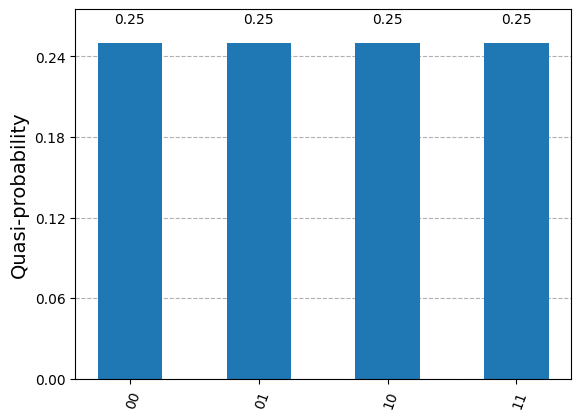

In [71]:
sim = AerSimulator(method="statevector")

# Simulamos
result = sim.run(transpile(qc_pinv,sim)).result()
estado_final = result.get_statevector()
display(estado_final.draw("latex"))

salida = result.get_counts()
plot_histogram(salida)

El problema es que, al medir, obtenemos con igual probabilidad cualquier valor de $|x\rangle$ ya que lo único que diferencia a $|x_i\rangle$ es la fase. Necesitamos convertir diferencias de fase en diferencias de amplitud.

## Amplificación de amplitud

La AA se basa en aumentar la amplitud de los estados que tengan una fase negativa. La idea básica es la *inversión sobre la media*.

Supongamos el vector (decimal) $v=[10,10,10,-10,10]^T$. La media de esos valores es $\overline{v}=6$.

Invertir sobre la media consiste en repetir esta operación:

$$
v^\prime = \overline{v} + (\overline{v}-v) = 2\overline{v} -v,\quad i = 0,1,2\ldots
$$

cambiando en cada iteración el signo del elemento negativo de $v$.

Aplicando esta operación al vector anterior obtenemos $v^\prime=[2,2,2,22,2]^T$. La media sigue siendo la misma pero el tercer valor, antes negativo, se separa del resto.

Si negamos el tercer elemento tenemos $v=[2,2,2,-22,2]^T$ de media $\overline{v}=-2.8$.

Repitiendo el procedimiento, obtenemos $v^\prime=[-7.6,-7.6,-7.6,16.4,-7.6]^T$. La diferencia entre $v[3]$ y el resto de valores pasa a ser de 24.

A medida que aplicamos la inversión sobre la media esta diferencia se agranda, pero llega un punto en que empieza a disminuir (cuando al invertir el elemento se igualan los signos). Se puede demostrar que para un vector de $N$ elementos, el número de inversiones que obtienen la máxima separación es $\mathcal{O}(\sqrt{N})$.

Podemos expresar este mecanismo usando matrices. Sea, de nuevo, $v=[10,10,10,-10,10]^T$ y la matriz:

$$
A=\frac{1}{5}
\begin{bmatrix}
1 & 1 & 1 & 1 & 1\\
1 & 1 & 1 & 1 & 1\\
1 & 1 & 1 & 1 & 1\\
1 & 1 & 1 & 1 & 1\\
1 & 1 & 1 & 1 & 1
\end{bmatrix}
$$

Está claro que $Av = [6,6,6,6,6]^T = [\overline{v}, \overline{v}, \overline{v}, \overline{v}, \overline{v}]^T$. La operación de inversión la podemos expresar como una operación matricial:

$$v^\prime=2Av-v=(2A-I)v$$

Para un vector de $2^n$ elementos, la matriz $2A-1$ será de $2^n\times 2^n$:
$$
2A-I=\frac{2}{2^n}
  \begin{bmatrix}
    1 & 1 & \dots & 1 \\
    1 & 1 & \dots & 1 \\
    \vdots & \vdots & \ddots & \vdots \\
    1 & 1 & \dots & 1
  \end{bmatrix}-
  \begin{bmatrix}
    1 & 0 & \dots & 0 \\
    0 & 1 & \dots & 0 \\
    \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & \dots & 1
  \end{bmatrix} =\frac{1}{2^{n-1}}
  \begin{bmatrix}
    1-2^{n-1} & 1 & \dots & 1 \\
    1 & 1-2^{n-1} & \dots & 1 \\
    \vdots & \vdots & \ddots & \vdots \\
    1 & 1 & \dots & 1-2^{n-1}
  \end{bmatrix}
$$

Se puede demostrar que $U = 2A-I$ es una matriz unitaria, por lo que se puede contruir en un circuito cuántico.


Para el caso de 2 cúbits, la matriz $2A-I$ queda:
$$
2A-I=\frac{1}{2}
  \begin{bmatrix}
    -1 & 1 & 1 & 1 \\
    1 & -1 & 1 & 1 \\
    1 & 1 & -1 & 1 \\
    1 & 1 & 1 & -1
  \end{bmatrix}
$$

Esta matriz, que se llama operador de difusión o _difusor_ $R_s$, se puede implementar (para $n=2$) con el siguiente circuito:

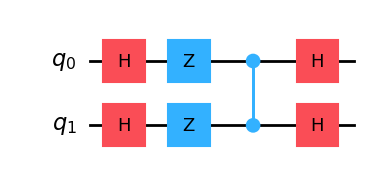

<IPython.core.display.Latex object>

In [72]:
n=2
qc_aa = QuantumCircuit(n)
for q in range(n):
    qc_aa.h(q)
    qc_aa.z(q)

qc_aa.cz(0,1)

for q in range(n):
    qc_aa.h(q)

display(qc_aa.draw('mpl'))

obten_unitaria(qc_aa, '2A-I = ')

Juntando la inversión de fase con la amplificación de amplitud, el circuito que implementa el algoritmo de Grover queda:

<center><img src="https://drive.google.com/uc?export=view&id=1zHNncIAcNP5Cyew3TgiKhpMGEAfagPW2" alt="Grover completo" width="800"  /></center>

Se puede demostrar que el número de repeticiones óptimo es:

$$
N_{reps} \approx \frac{\pi}{4}\sqrt{2^n}
$$

El el caso de tener $k$ elementos marcados, con $k \ll 2^n$, el número de repeticiones adecuado es:

$$
N_{reps} =  \left\lfloor\frac{\pi}{4}\sqrt{2^n/k}\right\rfloor
$$

# **Transformada de Fourier cuántica (QFT)** <a name="qft"></a>

La [transformada discreta de Fourier](https://es.wikipedia.org/wiki/Transformada_de_Fourier_discreta) actúa sobre un vector $x=(x_0, ..., x_{N-1})$ y lo transforma en un vector  $\widetilde{x}=(\widetilde{x}_0,\ldots,\widetilde{x}_{N-1})$ según la siguiente ecuación:


$$\widetilde{x}_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{kj}$$


donde $\omega_N^{kj} = e^{\frac{2\pi i}{N}{kj}}$.

De forma similar, la transformada cuántica de Fourier actúa en un estado cuántico de $n$ cúbits $|x\rangle = \sum_{i=0}^{N-1} x_i \vert i \rangle$, con $N=2^n$, y lo transforma en el estado cuántico $|\widetilde{x}\rangle = \sum_{i=0}^{N-1} \widetilde{x}_i \vert i \rangle$ según la siguiente ecuación:


$$\widetilde{x}_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{kj}$$


con $\omega_N^{kj}$ igual que antes.

La complejidad de la QFT al calcular la transformada de un vector de tamaño $N$ es $\mathcal{O}(\log^2N)$, frente a la versión clásica (FFT) que es $\mathcal{O}(N\log N)$



---

**Ejemplo**: QFT de 1 cúbit (N=2)

Sea $|x\rangle = x_0|0\rangle+x_1|1\rangle$.

Como $\omega_2 = e^{\frac{2\pi i}{N}} = e^{\pi i}$, tenemos:

$$
\widetilde x_0 = \frac{1}{\sqrt{2}}\left[x_0 \omega_2^{0\cdot 0} + x_1 \omega_2^{0\cdot 1}\right] = \frac{1}{\sqrt{2}}\left[x_0+ x_1\right]\\
\widetilde x_1 = \frac{1}{\sqrt{2}}\left[x_0 \omega_2^{0\cdot 1} + x_1 \omega_2^{1\cdot 1}\right] = \frac{1}{\sqrt{2}}\left[x_0+ x_1 e^{\pi i}\right] = \frac{1}{\sqrt{2}}\left[x_0- x_1\right]
$$

El estado transformado es, por tanto:

$$
|\widetilde{x}\rangle =
\frac{1}{\sqrt{2}}
\begin{bmatrix}
x_0 + x_1\\
x_0 - x_1
\end{bmatrix} =
\frac{1}{\sqrt{2}}
\begin{bmatrix}
1 & 1\\
1 & -1
\end{bmatrix}
\begin{bmatrix}
x_0\\
x_1
\end{bmatrix} = H|x\rangle
$$

La puerta Hadamard implementa la QFT de 1 qubit.


---



#### Matriz unitaria de la QFT

Podemos expresar la QFT como una operación matricial:

$$
\begin{aligned}
\begin{bmatrix}
\widetilde{x}_0\\
\widetilde{x}_1\\
\widetilde{x}_2\\
\widetilde{x}_3\\
\vdots \\
\widetilde{x}_{N-1}
\end{bmatrix} = \frac{1}{\sqrt{N}}
\begin{bmatrix}
\omega^{0\cdot 0} & \omega^{0\cdot 1} & \omega^{0\cdot 2} & \omega^{0\cdot 3} &\dots & \omega^{0\cdot (N-1)}\\
\omega^{1\cdot 0} & \omega^{1\cdot 1} & \omega^{1\cdot 2} & \omega^{1\cdot 3} & \dots & \omega^{1\cdot (N-1)}\\
\omega^{2\cdot 0} & \omega^{2\cdot 1} & \omega^{2\cdot 2} & \omega^{2\cdot 3} &\dots & \omega^{2\cdot (N-1)}\\
\omega^{3\cdot 0} & \omega^{3\cdot 1} & \omega^{3\cdot 2} & \omega^{3\cdot 3} & \dots & \omega^{3\cdot (N-1)}\\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
\omega^{(N-1)\cdot 0} & \omega^{(N-1)\cdot 1} & \omega^{(N-1)\cdot 2} & \omega^{(N-1)\cdot 3} & \dots & \omega^{(N-1)\cdot (N-1)}
\end{bmatrix}
\begin{bmatrix}
x_0\\
x_1\\
x_2\\
x_3\\
\vdots \\
x_{N-1}
\end{bmatrix}\\[10pt]
= \frac{1}{\sqrt{N}}
\begin{bmatrix}
1 & 1 & 1 & 1 &\dots & 1\\
1 & \omega & \omega^2 & \omega^3 & \dots & \omega^{N-1}\\
1 & \omega^{2} & \omega^{4} & \omega^{6} &\dots & \omega^{2(N-1)}\\
1 & \omega^{3} & \omega^{6} & \omega^{9} & \dots & \omega^{3(N-1)}\\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
1 & \omega^{N-1} & \omega^{2(N-1)} & \omega^{3(N-1)} & \dots & \omega^{(N-1)^2}
\end{bmatrix}
\begin{bmatrix}
x_0\\
x_1\\
x_2\\
x_3\\
\vdots \\
x_{N-1}
\end{bmatrix}
\end{aligned}
$$

Esta matriz $U_{QFT}$ es una matriz unitaria, que puede usarse como una puerta.

También puede escribirse como:

$$
U_{QFT} = \frac{1}{\sqrt{N}}\sum_{j,k=0}^{N-1} \omega_N^{jk}|k\rangle\langle j| = \frac{1}{\sqrt{N}}\sum_{j,k=0}^{N-1} e^{\frac{2\pi i}{N}{jk}}|k\rangle\langle j|
$$

ya que $|k\rangle\langle j|$ es una matriz $N\times N$ que tiene un 1 en la fila $k$, columna $j$, y 0 en el resto.



---

**Ejemplo**

Sea $n=3$ ($N=8$) y el estado $|x\rangle = |101\rangle$. La QFT de $|x\rangle$ es:

$$
U_{QFT}|101\rangle = \frac{1}{\sqrt{8}}
\begin{bmatrix}
1 &     1    &     1       &      1      &     1       &     1       &     1       & 1       \\
1 & \omega   & \omega^2    & \omega^3    & \omega^4    & \omega^5    & \omega^6    & \omega^7\\
1 & \omega^2 & \omega^4    & \omega^6    & \omega^8    & \omega^{10} & \omega^{12} & \omega^{14}\\
1 & \omega^3 & \omega^6    & \omega^9    & \omega^{12} & \omega^{15} & \omega^{18} & \omega^{21}\\
1 & \omega^4 & \omega^8    & \omega^{12} & \omega^{16} & \omega^{20} & \omega^{24} & \omega^{28}\\
1 & \omega^5 & \omega^{10} & \omega^{15} & \omega^{20} & \omega^{25} & \omega^{30} & \omega^{35}\\
1 & \omega^6 & \omega^{12} & \omega^{18} & \omega^{24} & \omega^{30} & \omega^{36} & \omega^{42}\\
1 & \omega^7 & \omega^{14} & \omega^{21} & \omega^{28} & \omega^{35} & \omega^{42} & \omega^{49}\\
\end{bmatrix}
\begin{bmatrix}
0\\
0\\
0\\
0\\
0\\
1\\
0\\
0
\end{bmatrix} = \frac{1}{\sqrt{8}}
\begin{bmatrix}
    1             \\
 \omega^5    \\
 \omega^{10} \\
 \omega^{15} \\
 \omega^{20} \\
 \omega^{25} \\
 \omega^{30} \\
 \omega^{35}\\
\end{bmatrix}
$$

Y como $\omega = e^\frac{2\pi i}{8} = e^{\frac{\pi}{4}i}$:

$$
U_{QFT}|101\rangle =  
\frac{1}{\sqrt{8}}
\begin{bmatrix}
    1             \\
 e^{\frac{5\pi}{4}i}    \\
 e^{\frac{10\pi}{4}i} \\
 e^{\frac{15\pi}{4}i} \\
 e^{\frac{20\pi}{4}i} \\
 e^{\frac{25\pi}{4}i} \\
 e^{\frac{30\pi}{4}i} \\
 e^{\frac{35\pi}{4}i}\\
\end{bmatrix} =  
\frac{1}{\sqrt{8}}
\begin{bmatrix}
    1             \\
 -\frac{1}{\sqrt{2}}(1+i)    \\
 i \\
 \frac{1}{\sqrt{2}}(1-i) \\
 -1 \\
 \frac{1}{\sqrt{2}}(1+i) \\
 -i \\
 -\frac{1}{\sqrt{2}}(1-i)\\
\end{bmatrix}
$$

Este estado también se puede escribir como:

$$
U_{QFT}|101\rangle =  
\frac{1}{\sqrt{8}}\left[\left(|0\rangle + e^{5\pi i}|1\rangle\right) \otimes
\left(|0\rangle + e^{\frac{5\pi}{2} i}|1\rangle\right)\otimes
\left(|0\rangle + e^{\frac{5\pi}{4} i}|1\rangle\right) \right]
$$

Es decir, la QFT pone a los cúbits en superposición y les aplica una rotación.

---



En general, la QFT transforma entre 2 bases: la base $\{|0\rangle, |1\rangle\}$ (o base computacional, también llamada base $Z$) a la base Fourier:

$$
|\text{Estado en la base computacional}\rangle \quad \xrightarrow[]{\text{QFT}} \quad |\text{Estado en la base de Fourier}\rangle
$$

En el caso de 1 cúbit, la QFT transforma $\{|0\rangle, |1\rangle\} \rightarrow \{|+\rangle, |-\rangle\}$, es decir, de la base $Z$ a la base $X$

En la siguiente imagen se muestra, en un estado de 4 cúbits, como cambia cada uno de ellos al ir avanzando desde el estado $|q_3q_2q_1q_0\rangle=|0000\rangle = |0\rangle$ al $|q_3q_2q_1q_0\rangle=|1111\rangle = |15\rangle$ (la esfera de la derecha corresponde al bit más significativo).

<center><img src="https://drive.google.com/uc?export=view&id=1V9W9AsvxoWTniW_yJGO5Huz80HnRF9rv" alt="Cúbits en base Z" width="800"  /></center>

El bit menos significativo ($|q_0\rangle$) cambia en cada incremento, el $|q_1\rangle$ cada 2, el $|q_2\rangle$ cada 4 y el $|q_3\rangle$ cada 8.

En la base de Fourier, esos números se corresponden a rotaciones alrededor del eje Z:

<center><img src="https://drive.google.com/uc?export=view&id=1i7GIjvICJao7dbw7b8WOXwOZKnPVIpkY" alt="Cúbits en base Fourier" width="800"  /></center>

En el estado $|\widetilde{0}\rangle$ todos los cúbits están en el estado $|+\rangle$. Por cada incremento, los cúbits rotan un ángulo diferente:

$$
|\widetilde{q}_0\rangle \text{ rota un ángulo } \frac{2\pi}{2^n} = \frac{\pi}{8} \\
|\widetilde{q}_1\rangle \text{ rota un ángulo } \frac{2\pi}{2^{n-1}} = \frac{\pi}{4}\\
|\widetilde{q}_2\rangle \text{ rota un ángulo } \frac{2\pi}{2^{n-2}} = \frac{\pi}{2}\\
|\widetilde{q}_3\rangle \text{ rota un ángulo } \frac{2\pi}{2^{n-3}} = \pi
$$

Así, en el ejemplo anterior de tres cúbits, para alcanzar el estado $|\widetilde{5}\rangle$, las rotaciones serían:

$$
|\widetilde{q}_0\rangle \text{ rota un ángulo } 5\times \frac{2\pi}{2^3} = \frac{5\pi}{4} \\
|\widetilde{q}_1\rangle \text{ rota un ángulo } 5\times \frac{2\pi}{2^{3-1}} = \frac{5\pi}{2}\\
|\widetilde{q}_2\rangle \text{ rota un ángulo } 5\times \frac{2\pi}{2^{2-2}} = 5\pi
$$

En general, con $n$ cúbits, pasar del estado $|\widetilde{0}\rangle$ al $|\widetilde{2^{n-1}}\rangle$ en la base Fourier implica que el cúbit menos significativo da una vuelta completa en torno al eje z, el segundo, 2 vueltas, el tercero, 4, y así sucesivamente.

<details>
<summary>Obtención de $U_{QFT}$ como puertas simples.</summary>

Sea $|z\rangle$ un estado simple $|z\rangle=|z_{n-1}z_{n-2}\ldots z_0\rangle$ con $z_i\in \{0,1\}$. Si aplicamos $U_{QFT}$:

$$
U_{QFT}|z\rangle =  \frac{1}{\sqrt{N}}\sum_{j,k=0}^{N-1} e^{\frac{2\pi i}{N}{jk}}|k\rangle\langle j|z\rangle = \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1} e^{2\pi i\frac{zk}{N}}|k\rangle
$$

ya que $\langle j|z\rangle = \delta_{jz}$ (es 1 si $j=z$, 0 en otro caso).

Como $|k\rangle=|k_{n-1}k_{n-2}\ldots k_0\rangle$ con $k_i\in \{0,1\}$, podemos escribir el entero $k$ como:

$$
k = 2^{n-1}k_{n-1}+2^{n-2}k_{n-2}+\ldots+2^0k_0
$$

Dividiendo entre $N=2^n$:

$$
\frac{k}{N} = \frac{k}{2^n} = \frac{k_{n-1}}{2}+\frac{k_{n-2}}{2^2}+\ldots+\frac{k_0}{2^n}
$$

Por tanto, podemos escribir la exponencial de la transformada como:

$$
\exp\left(2\pi i\frac{zk}{N}\right) = \exp\left[2\pi iz\left(\frac{k_{n-1}}{2}+\frac{k_{n-2}}{2^2}+\ldots+\frac{k_0}{2^n}\right)\right] =
\exp\left[2\pi iz\left(\frac{k_{n-1}}{2}\right)\right]\cdot
\exp\left[2\pi iz\left(\frac{k_{n-2}}{2^2}\right)\right]
\cdot\ldots\cdot\exp\left[2\pi iz\left(\frac{k_0}{2^n}\right)\right] = \prod_{l=1}^{n} \exp\left[2\pi iz\left(\frac{m_l}{2^{l}}\right)\right]
$$

donde $m_l=k_{n-l}$.

Escribiendo entonces $|k\rangle=|k_{n-1}k_{n-2}\ldots k_0\rangle = |m_1m_2\ldots m_n\rangle = |m_1\rangle\otimes |m_2\rangle \otimes\ldots\otimes |m_n\rangle$  (con $m_i\in \{0,1\}$):

$$
\begin{aligned}
U_{QFT}|z\rangle & = \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1} \prod_{l=1}^{n} \exp\left[2\pi iz\left(\frac{m_l}{2^{l}}\right)\right] |k\rangle \\
& = \frac{1}{\sqrt{N}}\sum_{m_i\in \{0,1\}} \prod_{l=1}^{n} e^{2\pi izm_l/2^l} (|m_1\rangle\otimes |m_2\rangle \otimes\ldots\otimes |m_n\rangle)
\end{aligned}
$$

Como se verifica que $a b(A\otimes B) = (ab A) \otimes B = A \otimes (ab B) = aA \otimes bB$, podemos escribir

$$
\begin{aligned}
U_{QFT}|z\rangle & = \frac{1}{\sqrt{N}}\sum_{m_i\in \{0,1\}}  (e^{2\pi izm_1/2^1}|m_1\rangle\otimes e^{2\pi izm_2/2^2}|m_2\rangle \otimes\ldots\otimes e^{2\pi izm_n/2^n}|m_n\rangle) \\
&= \frac{1}{\sqrt{N}}\bigotimes_{l=1}^n \sum_{m_l\in\{0,1\}} e^{2\pi izm_l/2^l}|m_l\rangle\\
& =
\frac{1}{\sqrt{2^n}}\bigotimes_{l=1}^n \left[|0\rangle + e^{2\pi iz/2^l}|1\rangle\right]
\end{aligned}
$$

en esta última expresión, el factor del 0 corresponde a $m_l=0$ y el del 1 a $m_l=1$.

Por lo que podemos escribir la transformada como:

$$
U_{QFT}|z\rangle  =
\frac{1}{\sqrt{2^n}}\left[
\left(\vert0\rangle + \exp\left({\frac{2\pi i}{2}z}\right) \vert1\rangle\right)
\otimes
\left(\vert0\rangle + \exp\left({\frac{2\pi i}{2^2}z}\right) \vert1\rangle\right)
\otimes  
\cdots\\
\otimes
\left(\vert0\rangle + \exp\left({\frac{2\pi i}{2^{n-1}}z}\right) \vert1\rangle\right)
\otimes
\left(\vert0\rangle + \exp\left({\frac{2\pi i}{2^n}z}\right) \vert1\rangle\right)
\right]
$$

<!--
$$
\begin{aligned}
U_{QFT}|z\rangle & = \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1} \prod_{l=1}^{n} \exp\left[2\pi iz\left(\frac{m_l}{2^{l}}\right)\right] |k\rangle  \\
& = \frac{1}{\sqrt{N}}\left(e^{2\pi izm_1/2^1}|m_1\rangle \otimes e^{2\pi izm_2/2^2}|m_2\rangle \otimes \ldots \otimes e^{2\pi izm_n/2^n}|m_n\rangle\right) \\
& = \frac{1}{\sqrt{N}}\bigotimes_{l=1}^n \sum_{m_l\in\{0,1\}} e^{2\pi izm_l/2^l}|m_l\rangle \text{ (ya que }m_i\in \{0,1\} \forall i\text{)}\\
& =
\frac{1}{\sqrt{2^n}}\bigotimes_{l=1}^n \left[|0\rangle + e^{2\pi iz/2^l}|1\rangle\right] \text{ (el factor del 0 corresponde a }m_l=0\text{ y el del 1 a }m_l=1\\
& =\frac{1}{\sqrt{2^n}}\left[
\left(\vert0\rangle + \exp\left({\frac{2\pi i}{2}z}\right) \vert1\rangle\right)
\otimes
\left(\vert0\rangle + \exp\left({\frac{2\pi i}{2^2}z}\right) \vert1\rangle\right)
\otimes  
\ldots
\otimes
\left(\vert0\rangle + \exp\left({\frac{2\pi i}{2^{n-1}}z}\right) \vert1\rangle\right)
\otimes
\left(\vert0\rangle + \exp\left({\frac{2\pi i}{2^n}z}\right) \vert1\rangle\right)
\right]
\end{aligned}
$$
-->

Estas operaciones podemos implementarlas mediante puertas _phase_ del tipo:

$$\text{UROT}_k = \left[\begin{matrix}
1&0\\
0&\exp\left(\frac{2\pi i}{2^k}\right)\\
\end{matrix}\right]$$

y la versión controlada de esta puerta:

$$\text{C-UROT}_k = \left[\begin{matrix}
I&0\\
0&UROT_k\\
\end{matrix}\right]$$
</details>

### Circuito que implementa la QFT

Un circuito que implementa una QFT de n cúbits es:

<center><img src="https://drive.google.com/uc?export=view&id=12JP1GYo0aYFKHsOhg3PQDW2VqFBCtsdS" alt="QFT" width="1000"  /></center>

Siendo las puertas $\text{UROT}_k$ de tipo _phase_:

$$\text{UROT}_k = \left[\begin{matrix}
1&0\\
0&\exp\left(\frac{2\pi i}{2^k}\right)\\
\end{matrix}\right]$$

con $2\le k \le n$.

<details>
<summary>Funcionamiento del circuito</summary>
El circuito empieza con el estado inicial $|x\rangle=|x_1x_{2}\ldots x_n\rangle$.
<ol>
<li>Después de la primera Hadamard sobre el cúbit 1, el estado queda:

$$
H_1\vert x_1x_2\ldots x_n\rangle =
\frac{1}{\sqrt{2}}
\left[\vert0\rangle \pm \vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle =
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2}x_1\right)\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

ya que si $x_1=0 \Rightarrow \exp\left({\frac{2\pi i}{2}x_1}\right) = 1$ y si $x_1=1 \Rightarrow \exp\left({\frac{2\pi i}{2}x_1}\right) = e^{\pi i} = -1$
    <p></p>
    
<li> Después de aplicar la puerta $\text{UROT}_2$ sobre el cúbit 1 controlado por el cúbit 2, tenemos:

$$
\begin{cases}
\text{si } x_2 = 0 \rightarrow \frac{1}{\sqrt{2}}
\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2}x_1\right)\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle\\
\text{si } x_2 = 1 \rightarrow \frac{1}{\sqrt{2}}
\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2^2}\right)\exp\left(\frac{2\pi i}{2}x_1\right)\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle\\
\end{cases}
$$

que se puede escribir como:
$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1\right)\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$
    <p></p>

<li> Después de la aplicación de la última puerta $\text{UROT}_n$ (controlada por el cúbit n) sobre el cúbit 1, el estado queda:

$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^n}x_n +
\frac{2\pi i}{2^{n-1}}x_{n-1} +
\ldots +
\frac{2\pi i}{2^2}x_2 +
\frac{2\pi i}{2}x_1
\right)
\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

Y como:

$$
x = 2^{n-1}x_1 + 2^{n-2}x_2 + \ldots + 2^1x_{n-1} + 2^0x_n \Rightarrow \frac{x}{2^n} =
\frac{x_1}{2} + \frac{x_1}{2^2}  + \ldots + \frac{x_{n-1}}{2^{n-1}} + \frac{x_{n}}{2^{n}}
$$

podemos escribir el estado anterior como:

$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^n}x
\right)
\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$
<p></p>
    
<li> El estado después de aplicar una secuencia similar de puertas para los cúbits $2\ldots n$ será:  

$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^n}x
\right)
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^{n-1}}x
\right)
\vert1\rangle\right]
\otimes
\cdots
\otimes
\frac{1}{\sqrt{2}}
\left[\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^{2}}x
\right)
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^{1}}x
\right)
\vert1\rangle\right]
$$

que es la expresión de la QFT que vimos antes, pero con los cúbits en orden inverso, por lo que es necesario una operación de inversión para obtener el resultado correcto.
</ol>

</details>



---


**Ejemplo**: Ejemplo con tres bits. Obtener la QFT de $|101\rangle$

Las puertas que necesitamos son la $\text{C-UROT}_2$ y la $\text{C-UROT}_3$, siendo:

$$
\text{UROT}_2 = \left[\begin{matrix}
1&0\\
0&\exp\left(\frac{2\pi i}{2^2}\right)\\
\end{matrix}\right] =
\left[\begin{matrix}
1&0\\
0&\exp\left(\frac{\pi i}{2}\right)\\
\end{matrix}\right] = R_{\pi/2}
$$

$$
\text{UROT}_3 = \left[\begin{matrix}
1&0\\
0&\exp\left(\frac{2\pi i}{2^3}\right)\\
\end{matrix}\right] =
\left[\begin{matrix}
1&0\\
0&\exp\left(\frac{\pi i}{4}\right)\\
\end{matrix}\right] = R_{\pi/4}
$$

Por lo tanto, necesitamos puertas _phase-shift_ controladas.


---



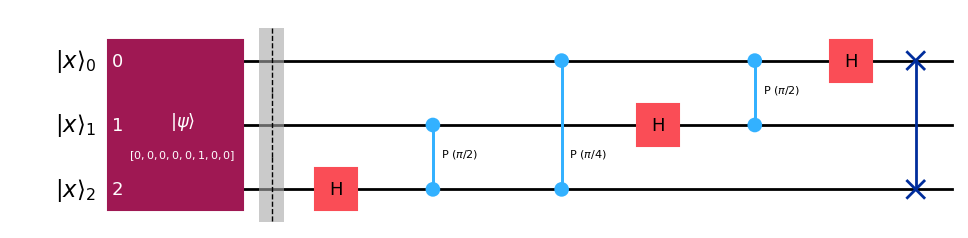

<IPython.core.display.Latex object>

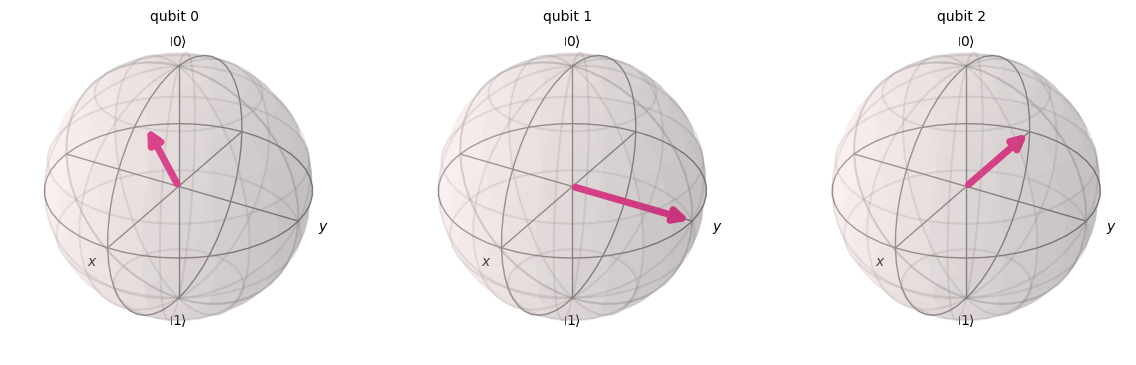

In [73]:
n = 3 # Tres cúbits
v = 5 # valor a calcular

x = QuantumRegister(n, name='|x\\rangle')
qft = QuantumCircuit(x)
qft.initialize(Statevector.from_int(v, dims=2**n))

qft.barrier()

# Recordemos que en Qiskit los cúbits están en orden inverso al de la imagen anterior
# Aplicamos H sobre el cúbit más significativo
qft.h(2)

# Aplicamos la C-UROT2 que es una puerta phase de pi/2 controlada por q1
qft.cp(np.pi/2, 1, 2)

# Aplicamos la C-UROT3 que es una puerta phase de pi/4 controlada por q0
qft.cp(np.pi/4, 0, 2)

# Repetimos el proceso para q1
qft.h(1)
qft.cp(np.pi/2, 0, 1)

# Por último, para q0
qft.h(0)

# Para obtener el resultado correcto tenemos que invertir la salida
qft.swap(0,2)

display(qft.draw('mpl'))

# Mostramos el vector de estado de salida
obten_estado(qft, 'QFT|101\\rangle =')


La [librería de circuitos de Qiskit](https://docs.quantum.ibm.com/api/qiskit/circuit_library) proporciona una implementación de la QFT:

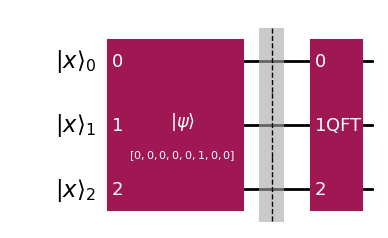

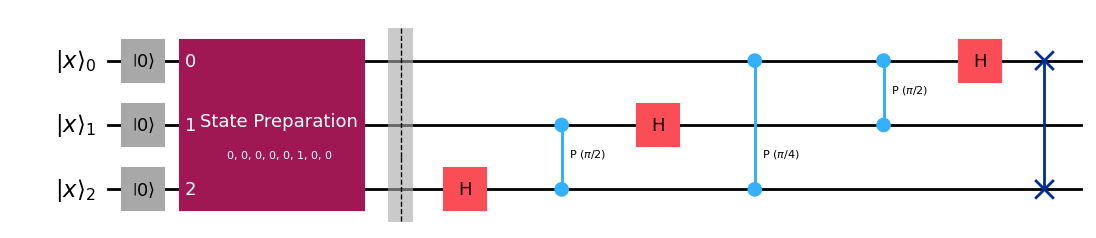

<IPython.core.display.Latex object>

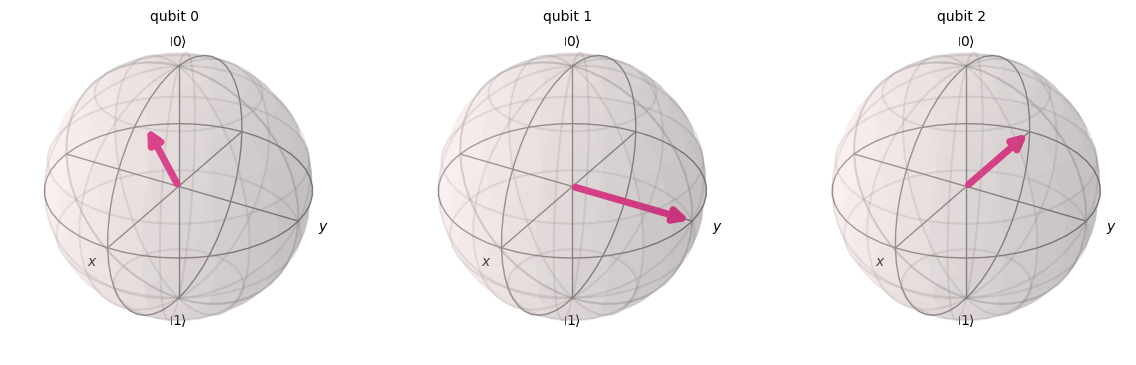

In [75]:
from qiskit.circuit.library import QFT

n = 3 # Tres cúbits
v = 5 # valor a calcular

x = QuantumRegister(3, name='|x\\rangle')
qft_qiskit = QuantumCircuit(x)
qft_qiskit.initialize(Statevector.from_int(v, dims=2**n))

qft_qiskit.barrier()

qft_qiskit.compose(QFT(n),inplace=True)

# Muesta el circuito
display(qft_qiskit.draw('mpl'))
display(qft_qiskit.decompose().draw('mpl'))

obten_estado(qft_qiskit, 'QFT|101\\rangle =')

La QFT inversa es igual pero invirtiendo la aplicación de las puertas:

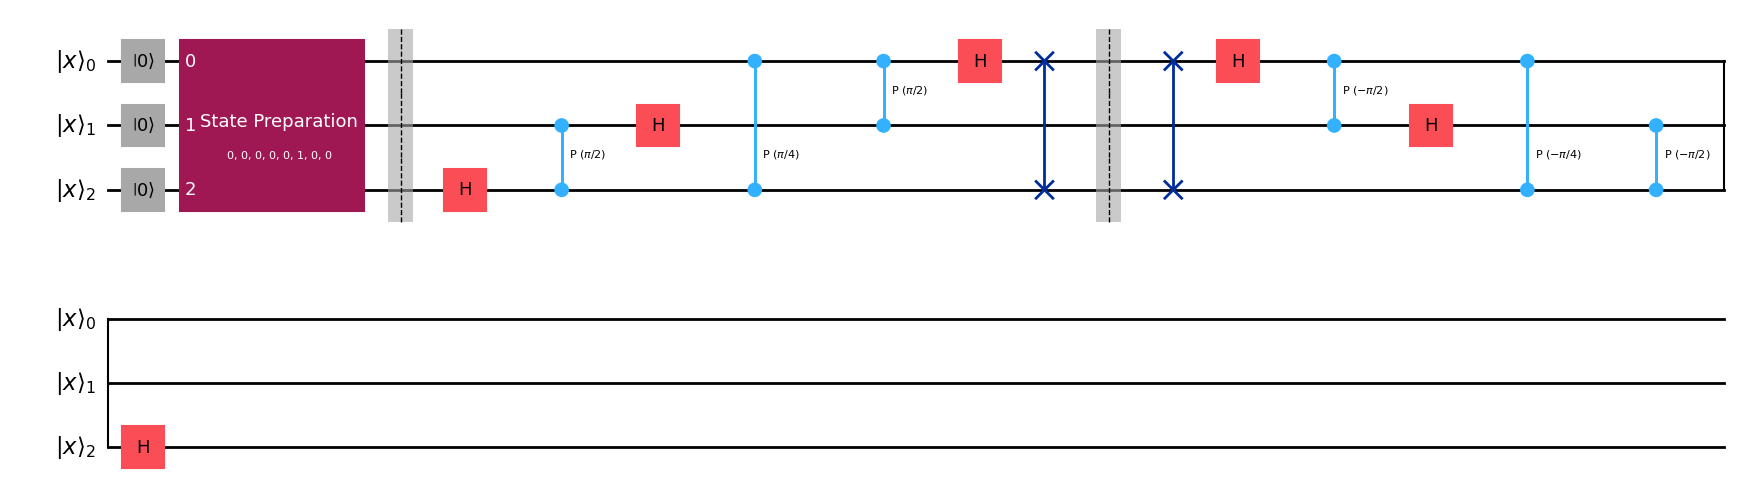

<IPython.core.display.Latex object>

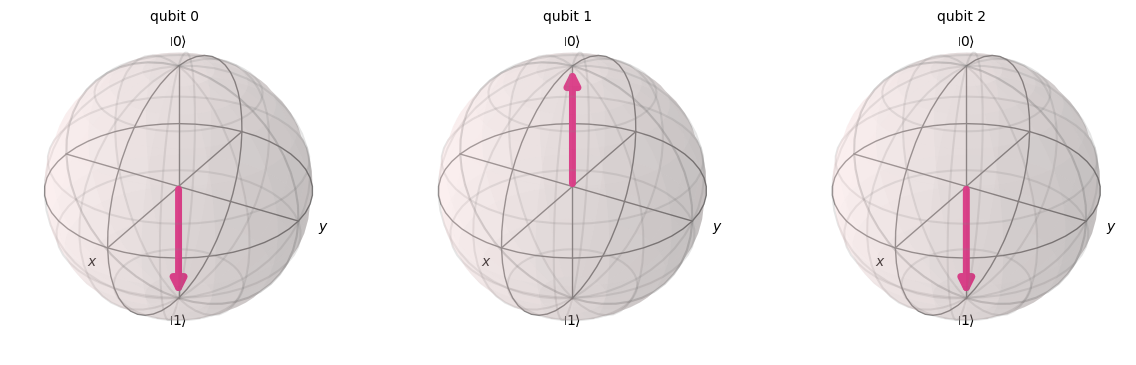

In [79]:
n = 3 # Tres cúbits
v = 5 # valor a calcular

x = QuantumRegister(3, name='|x\\rangle')
qft_qiskit = QuantumCircuit(x)
qft_qiskit.initialize(Statevector.from_int(v, dims=2**n))

qft_qiskit.barrier()

# QFT directa
qft_qiskit.compose(QFT(n),inplace=True)
qft_qiskit.barrier()

# QFT inversa
qft_qiskit.compose(QFT(n).inverse(),inplace=True)


# Muesta el circuito
display(qft_qiskit.decompose().draw('mpl'))

obten_estado(qft_qiskit, 'QFT^{-1}(QFT|101\\rangle) =')



---



---



---



# **Quantum phase estimation (QPE)** <a name="qpe"></a>

El algoritmo QPE es uno de los más importantes en QC, y es central en algoritmos más complejos.

Dada una matriz unitaria $U$ y uno de sus autovectores (o autoestados) $|\psi\rangle$, QPE determina el autovalor $e^{\boldsymbol{2\pi i}\theta}$ asociado.

$$
U|\psi\rangle = e^{\boldsymbol{2\pi i}\theta}|\psi\rangle
$$
Al ser $U$ unitaria, todos sus autovalores son números complejos de norma 1, por lo que se pueden escribir como $e^{\boldsymbol{2\pi i}\theta}$.
<details>
    <summary>Pulsa aquí para la demostración</summary>
    
Si $U$ es unitaria, verifica $U^\dagger U = UU^\dagger = I$. Sea $|v\rangle$ un autovector de $U$ y $\lambda\in \mathbb{C}$ el autovalor asociado. Tenemos:

$$
U|v\rangle = \lambda|v\rangle \Rightarrow \langle v|v\rangle = \langle v|U^\dagger U|v\rangle = \langle v|\lambda^*\lambda|v\rangle \Rightarrow \langle v|v\rangle = |\lambda|^2 \langle v|v\rangle
$$
    
Asumiendo $\lambda \ne 0$, para que la igualdad se cumpla es necesario que $|\lambda|^2 = 1 \Rightarrow \lambda = e^{i\phi}$ con $\phi\in\mathbb{R}$.
</details>



---

**Ejemplo**: Calcular el autovalor asociado al autovector |1⟩ de la puerta T

Recordemos que T aplica una rotación de $\frac{\pi}{4}$:

$$
T =
\begin{bmatrix}
1 & 0\\
0 & e^\frac{i\pi}{4}\\
\end{bmatrix}
$$

Por tanto:
$$ T|1\rangle =
\begin{bmatrix}
1 & 0\\
0 & e^\frac{i\pi}{4}\\
\end{bmatrix}
\begin{bmatrix}
0\\
1\\
\end{bmatrix}
= e^\frac{i\pi}{4}|1\rangle = e^{2i\pi\theta}|1\rangle$$

con $$\theta = \frac{1}{8}$$


---



## Circuito para la QPE


El circuito para QPE es el siguiente:

<center><img src="https://drive.google.com/uc?export=view&id=15SL16rv_A2IY5twrRw9nxBb5UcDHxsay" alt="Circuito QPE" width="1000"  /></center>


El registro superior contienen $t$ cúbits ancilla y el inferior esta en el autoestado $|\psi\rangle$ de $U$. A la salida, en los bits de ancilla se obtiene el estado $|2^t\theta\rangle$.

La idea del algoritmo es usar _phase-kickback_ para trasladar rotaciones proporcionales a la fase $e^{\boldsymbol{2\pi i}\theta}$ en la base Fourier, y luego aplicar una QFT inversa para pasar a la base computacional. El número $t$ de bits de ancilla va determinar la precisión del resultado.

Se puede demostrar que si $|\psi\rangle$ es un estado arbitrario, si usamos $|\psi\rangle$ como entrada en QPE, cualquier medida de los bits de ancilla, nos devuelve un autovalor de $U$.

<details>
<summary>Explicación del circuito</summary>
Pasos:

i. Estado inicial: $$ |\psi_0\rangle = \lvert 0 \rangle^{\otimes t} \lvert \psi \rangle$$
ii. Después de las puertas $H$ aplicadas a los cúbits de ancilla

$$
\begin{aligned}
|\psi_1\rangle &= \frac{1}{\sqrt{2^t}}\left(|0\rangle +|1\rangle \right)^{\otimes t} \lvert \psi \rangle\\[5pt]
&=\frac{1}{\sqrt{2^t}}\left[\left(|0\rangle +|1\rangle\right)\otimes\left(|0\rangle +|1\rangle\right)\otimes\cdots\otimes\left(|0\rangle +|1\rangle\right)\right]\otimes|\psi\rangle
\end{aligned}
$$

iii. Aplicamos la primera puerta $U^{2^{t-1}}$ controlada. Primero, podemos ver que, como $U|\psi\rangle = e^{\boldsymbol{2\pi i}\theta}|\psi\rangle$ vamos a tener:

$$
U^{2^{j}}|\psi\rangle = U^{2^{j}-1}U|\psi\rangle = U^{2^{j}-1}e^{\boldsymbol{2\pi i}\theta}|\psi\rangle =\cdots =e^{\boldsymbol{2\pi} i2^{j}\theta}|\psi \rangle
$$

Por tanto, el estado después de aplicar la $U^{2^{t-1}}$ controlada el phase-kickback traslada la fase al primer cúbit:

$$
\begin{aligned}
|\psi_2\rangle &=
\frac{1}{\sqrt{2^t}}\left[\left(|0\rangle +e^{\boldsymbol{2\pi} i2^{t-1}\theta}|1\rangle\right)\otimes\left(|0\rangle +|1\rangle\right)\otimes\cdots\otimes\left(|0\rangle +|1\rangle\right)\right]\otimes|\psi\rangle
\end{aligned}
$$

iv. Haciendo lo mismo con el resto de $U$ controladas, tendremos que el estado antes de la QFT inversa será:

$$
|\psi_3\rangle =
\frac{1}{\sqrt{2^t}}\left[\left(|0\rangle +e^{\boldsymbol{2\pi} i2^{t-1}\theta}|1\rangle\right)\otimes\left(|0\rangle +e^{\boldsymbol{2\pi} i2^{t-2}\theta}|1\rangle\right)\otimes\cdots\\
\otimes
\left(|0\rangle +e^{\boldsymbol{2\pi} i2^{1}\theta}|1\rangle\right)\otimes
\left(|0\rangle +e^{\boldsymbol{2\pi} i2^{0}\theta}|1\rangle\right)\right]|\psi\rangle
$$

v. Aplicación de la QFT inversa. Vimos que:

$$
U_{QFT}|z\rangle
=\frac{1}{\sqrt{2^n}}\left[
\left(\vert0\rangle + e^{{\frac{2\pi i}{2}z}} \vert1\rangle\right)
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}z} \vert1\rangle\right)
\otimes  
\cdots\\
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{n-1}}z} \vert1\rangle\right)
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^n}z} \vert1\rangle\right)
\right]
$$

Reemplazando $n$ por $t$ y haciendo $z = 2^t\theta$ en esta expresión, es fácil ver que el estado de los bits de ancilla es:

$$
|\psi_3^\text{ancilla}\rangle = U_{QFT}|2^t\theta\rangle
$$

Por lo que el estado de los cúbits de ancilla después de aplicar la QFT inversa será $|\tilde{\theta}\rangle_{t}$, siendo $\tilde{\theta} =2^t\theta\Rightarrow\theta=\tilde{\theta}/{2^t}$.

Al medir los bits de ancilla obtenemos el valor  $2^t\theta$.
</details>


---

**Ejemplo:** Circuito para calcular el autovalor asociado al autovector $|1\rangle$ de la puerta T usando $t=3$ ancillas.


La puerta T es una rotación $\pi/4$. Aplicamos las rotaciones $\pi/4$ controladas por las ancillas, recordando que los cúbits en Qiskit están ordenados en orden inverso, por lo que la $U^{2^2}$ estará controlada por $q_2$ y la $U^{2^0}$ por $q_0$. Además, por simplicidad aplicamos las rotaciones al revés.


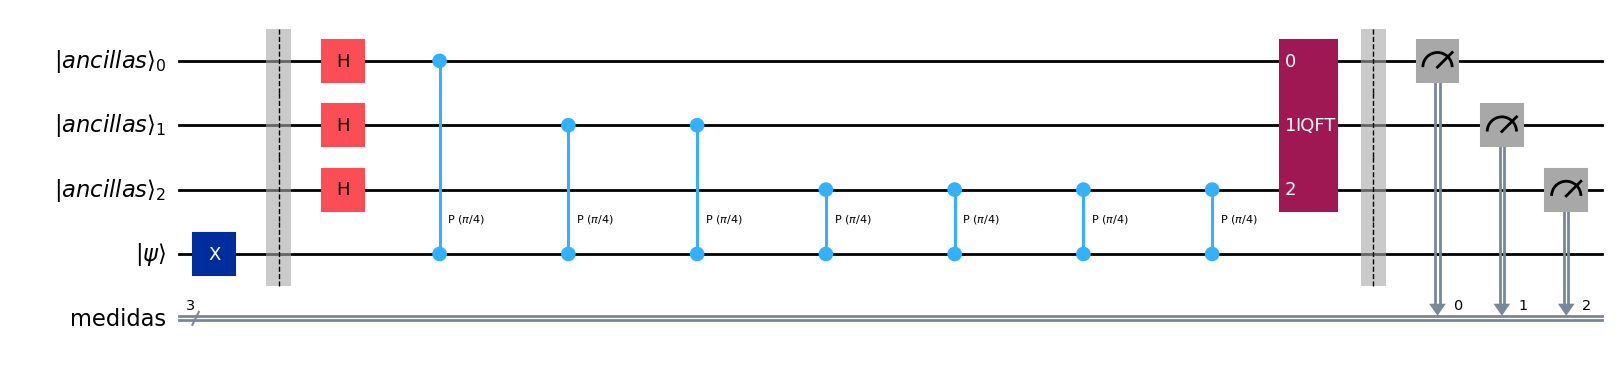

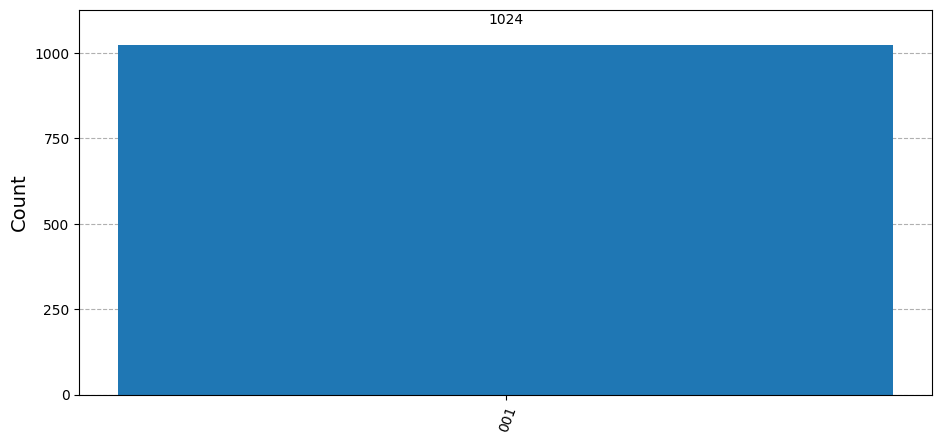

In [80]:
from qiskit.circuit.library import QFT

t = 3

ancillas = QuantumRegister(t, name='|ancillas\\rangle')
autoestado = QuantumRegister(1, name='|\psi\\rangle')
medidas = ClassicalRegister(t, name='medidas')

# 4 cúbits y 3 bits clásicos para medir las ancillas
qpe = QuantumCircuit(ancillas, autoestado, medidas)

# Ponemos |𝜓⟩ = 1
qpe.x(autoestado)

qpe.barrier()

# Ancillas en superposición
qpe.h(ancillas)

# Aplicamos las rotaciones 𝜋/4 controladas a las ancillas
repeticiones = 1
for counting_qubit in range(t):
    for i in range(repeticiones):
        qpe.cp(np.pi/4, counting_qubit, t); # Puerta C-T
    repeticiones *= 2

# Añadimos la QFT inversa
qpe.compose(QFT(t).inverse(),inplace=True)

qpe.barrier()

# Añadimos las medidas

qpe.measure(ancillas, medidas)

display(qpe.draw('mpl',style='iqp'))

sim = AerSimulator()
results = sim.run(transpile(qpe,sim), shots=1024).result()

answer = results.get_counts()
display(plot_histogram(answer, figsize=(11,5)))

El resultado es $\tilde{\theta}=1$. Recordemos que la salida del algoritmo QPE es $2^t\theta$. En este caso $t=3$, por lo que $\theta = \frac{\tilde{\theta}}{2^t} = \frac{1}{8}$



---



---



---



# **Algoritmo de factorización de Shor** <a name="shor"></a>

El algoritmo de Shor ([P.W. Shor, 1994](https://doi.org/10.1109%2Fsfcs.1994.365700)) permite factorizar enteros en un tiempo polinómico ($\mathcal{O}(\log N)^3$), a diferencia de los algoritmos clásicos que requieren un tiempo exponencial.

**Algoritmo**
Sea $N=p\cdot q$, siendo $p$ y $q$ números primos muy grandes. Dado $N$ buscamos su factorización.

Pasos:

1. Se elige $a < N$ tal que $\gcd(N,a) = 1$.
2. Se obtiene el período $r$ de la siguiente función:
$$
f_{a,N}(x) = a^x \bmod N
$$
3. Si $r$ es par y $a^{r/2} \bmod N \ne N-1$ se tiene que:
$$
p = \gcd(a^{r/2}-1, N), q = \gcd(a^{r/2}+1, N)
$$

El período de $f_{a,N}(x)$ es el menor entero $r>0$ para el que verifique que $f_{a,N}(r) = 1$. Calcular este período clásicamente tiene complejidad exponencial con $N$.





---

**Ejemplo**

Supongamos $N=15$ y elegimos $a=7$. La función $f_{7,15}(x)$ toma los siguientes valores:

In [81]:
N = 15
a = 7

xvals = np.arange(N)
yvals = [np.mod(a**x, N) for x in xvals]

print(yvals)

[1, 7, 4, 13, 1, 7, 4, 13, 1, 7, 4, 13, 1, 7, 4]


Vemos que el período es $r=4$.

Podemos representarlo gráficamente:

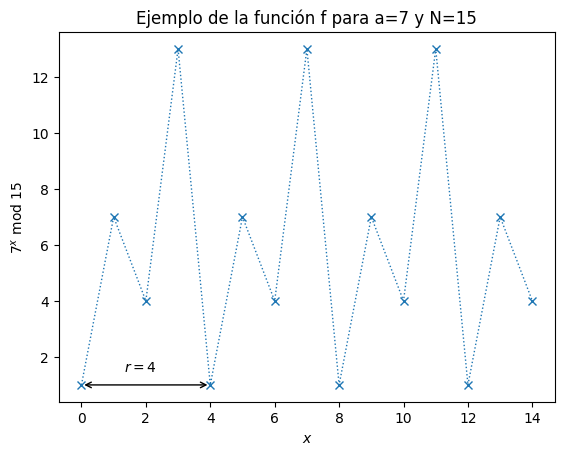

In [82]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Ejemplo de la función f para a={0} y N={1}".format(a,N))
try: # Muestra r sobre la gráfica
    r = yvals[1:].index(1) +1 # Indice del primer 1 en yvals (sin contar yvals[0])
    plt.annotate('', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate('$r=%i$' % r, xy=(r/3,1.5))
except ValueError:
    print('No puedo encontrar el período. Comprueba que a < N y que no tienen factores comunes.')

Como $a$ y $r$ cumplen lo indicado en el punto 3 anterior:

$$
p = \gcd(a^{r/2}-1, N) = \gcd(48, 15) = 3 \\[10pt]
q = \gcd(a^{r/2}+1, N) = \gcd(50, 15) = 5
$$



---



### Solución cuántica al cálculo del período

El algoritmo de Shor usa [QPE](#qpe) sobre el operador unitario:

$$U|y\rangle = |ay \bmod N\rangle$$

Al realizar sucesivas aplicaciones de $U$ sobre $|1\rangle$ vamos a ir obteniendo estados que corresponden a los valores de $f_{a,N}$.

Por ejemplo, con $a=7$ y $N = 15$:
$$\begin{aligned}
U^0|1\rangle &= |1\rangle \\
U^1|1\rangle &= |7 \bmod 15\rangle = |7\rangle \\
U^2|1\rangle &= UU|1\rangle = U|7\rangle = |49 \bmod 15\rangle = |4\rangle \\
U^3|1\rangle &= UU^2|1\rangle = U|4\rangle = |28 \bmod 15\rangle = |13\rangle\\
U^4|1\rangle &= UU^3|1\rangle = U|13\rangle = |91 \bmod 15\rangle = |1\rangle\\
U^5|1\rangle &= UU^4|1\rangle = U|1\rangle = |7\rangle
\end{aligned}$$




Los autoestados de $U$ tienen la siguiente forma:

$$
|u_s\rangle = \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i s k}{r}}|a^k \bmod N\rangle}
$$

con $s$ entero y $0\leq s < r$.

El autovalor asociado a $|u_s\rangle$ es $e^{\tfrac{2\pi i s}{r}}$:

$$U|u_s\rangle = e^{\tfrac{2\pi i s}{r}}|u_s\rangle
$$

<details>
<summary>Ejemplos de $|u_s\rangle$</summary>
Con $a=7$ y $N = 15$ ($r=4$)

$s=0$:

$$
|u_0\rangle = \tfrac{1}{\sqrt{4}}\sum_{k=0}^{3}|7^k \bmod 15\rangle = \tfrac{1}{2}(|1\rangle + |7\rangle + |4\rangle + |13\rangle)
$$

El autovalor asociado es 1:
$$\begin{aligned}
U|u_0\rangle &= \tfrac{1}{\sqrt{4}}(U|1\rangle + U|7\rangle + U|4\rangle + U|13\rangle) \\[10pt]
 &= \tfrac{1}{\sqrt{4}}(|7\rangle + |4\rangle + |13\rangle + |1\rangle) \\[10pt]
 &= |u_0\rangle
\end{aligned}$$

$s=1$:

$$
|u_1\rangle = \tfrac{1}{\sqrt{4}}\left(|1\rangle + e^{-\tfrac{2\pi i}{4}}|7\rangle + e^{-\tfrac{2\pi i2}{4}}|4\rangle + e^{-\tfrac{2\pi i3}{4}}|13\rangle\right)
$$

El autovalor asociado es $e^\tfrac{2\pi i}{4}$:

$$\begin{aligned}
U|u_1\rangle &= \tfrac{1}{\sqrt{4}}\left(U|1\rangle + e^{-\tfrac{2\pi i}{4}}U|7\rangle + e^{-\tfrac{2\pi i2}{4}}U|4\rangle + e^{-\tfrac{2\pi i3}{4}}U|13\rangle\right) \\[10pt]
 &= \tfrac{1}{\sqrt{4}}\left(|7\rangle + e^{-\tfrac{2\pi i}{4}}|4\rangle + e^{-\tfrac{2\pi i2}{4}}|13\rangle + e^{-\tfrac{2\pi i3}{4}}|1\rangle\right) \\[10pt]
 &= \tfrac{1}{\sqrt{4}}e^\tfrac{2\pi i}{4}\left(e^{-\tfrac{2\pi i}{4}}|7\rangle + e^{-\tfrac{2\pi i2}{4}}|4\rangle + e^{-\tfrac{2\pi i3}{4}}|13\rangle + e^{-\tfrac{2\pi i4}{4}}|1\rangle\right) \\[10pt]
 &= e^\tfrac{2\pi i}{4}|u_1\rangle
\end{aligned}$$


-----
</details>


Además, se puede comprobar que se verifica lo siguiente:

$$ \tfrac{1}{\sqrt{r}}\sum_{s=0}^{r-1} |u_s\rangle = |1\rangle$$

<details>
<summary>Ejemplo de esta suma</summary>
Con $a=7$ y $N = 15$ ($r=4$):

$$\begin{aligned}
|u_0\rangle &= \tfrac{1}{2}(|1\rangle \hphantom{e^{-\tfrac{2\pi i}{12}}}+ |7\rangle \hphantom{e^{-\tfrac{12\pi i}{12}}} + |4\rangle \hphantom{e^{-\tfrac{12\pi i}{12}}} + |13\rangle) \\[10pt]
|u_1\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{2\pi i}{4}}|7\rangle + e^{-\tfrac{\hphantom{1}4\pi i}{4}}|4\rangle + e^{-\tfrac{\hphantom{1}6\pi i}{4}}|13\rangle) \\[10pt]
|u_2\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{4\pi i}{4}}|7\rangle + e^{-\tfrac{\hphantom{1}8\pi i}{4}}|4\rangle + e^{-\tfrac{12\pi i}{4}}|13\rangle)\\[10pt]
|u_3\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{6\pi i}{4}}|7\rangle + e^{-\tfrac{12\pi i}{4}}|4\rangle + e^{-\tfrac{18\pi i}{4}}|13\rangle)
\end{aligned}$$

Con lo que la suma es:

$$
\tfrac{1}{\sqrt{4}}\sum_{s=0}^{3} |u_s\rangle = \tfrac{1}{2}(|u_0\rangle + |u_1\rangle + |u_1\rangle + |u_3\rangle) = \\
\frac{1}{2}\left(4|1\rangle + (1+e^{-\tfrac{2\pi i}{4}}+e^{-\tfrac{4\pi i}{4}}+e^{-\tfrac{6\pi i}{4}})|7\rangle +\\
(1+e^{-\tfrac{\hphantom{1}4\pi i}{4}}+e^{-\tfrac{\hphantom{1}8\pi i}{4}}|4\rangle+e^{-\tfrac{12\pi i}{4}})|4\rangle \\
+ (1+e^{-\tfrac{\hphantom{1}6\pi i}{4}}+e^{-\tfrac{12\pi i}{4}}+e^{-\tfrac{18\pi i}{4}})|13\rangle
\right)
$$

Y como:

$$
\begin{aligned}
e^{-\tfrac{2\pi i}{4}} &= e^{-\tfrac{\pi i}{2}} = -i\\
e^{-\tfrac{4\pi i}{4}} &= e^{-{\pi i}} = -1\\
e^{-\tfrac{6\pi i}{4}} &= e^{-\tfrac{3\pi i}{2}} = +i\\
e^{-\tfrac{8\pi i}{4}} &= e^{-{2\pi i}} = e^{0} = +1\\
e^{-\tfrac{12\pi i}{4}} &= e^{-{3\pi i}} = e^{-{\pi i}} = -1\\
e^{-\tfrac{18\pi i}{4}} &= e^{-\tfrac{9\pi i}{2}} = e^{-\tfrac{\pi i}{2}} = -i
\end{aligned}
$$

queda:

$$
\tfrac{1}{\sqrt{4}}\sum_{s=0}^{3} |u_s\rangle = 2|1\rangle = |1\rangle
$$

-----
</details>

Por tanto, aplicamos $U$ al estado $|1\rangle$ vamos a poder escribir:

$$
U|1\rangle = \tfrac{1}{\sqrt{r}}\sum_{s=0}^{r-1} U|u_s\rangle = \tfrac{1}{\sqrt{r}}\sum_{s=0}^{r-1} e^{\tfrac{2\pi i s}{r}}|u_s\rangle = \tfrac{1}{\sqrt{r}}\sum_{s=0}^{r-1} e^{2\pi i \theta}|u_s\rangle
$$

con $\theta = s/r$.

Por lo tanto, si aplicamos QPE a $U$ usando como autoestado $|1\rangle$, la salida nos va a devolver una fase $\theta = s/r$, siendo $s$ un entero con $0\leq s < r$. Obteniendo diferentes autovalores podemos obtener $r$ y, por lo tanto, los factores de $N$.

El esquema de un circuito que implementa este algoritmo (con el orden de cúbits usado en qiskit) es:


<center><img src="https://drive.google.com/uc?export=view&id=1BDRZ8e_I8tmIzB2taOi_UuaBqt9e0xcR" alt="Circuito Shor" width="1000"  /></center>


El cuello de botella del algoritmo de Shor reside en la creación de las puertas $U^{2^j}$. Existen diferentes alternativas. Un ejemplo simple está descrito en [S. Beauregard, 2003](https://arxiv.org/abs/quant-ph/0205095). Una implementación reciente para los sistemas de IBM está en [U. Skosana & M. Tame, 2021](https://doi.org/10.1038/s41598-021-95973-w). En [C. Gidney & M. Ekerå (2021)](https://doi.org/10.22331/q-2021-04-15-433) se demuestra que con 20 millones de cúbits con ruido se puede romper el algoritmo RSA de 2048 bits en solo 8 horas.